<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Formulas" data-toc-modified-id="Formulas-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Formulas</a></span></li><li><span><a href="#Function-definitions" data-toc-modified-id="Function-definitions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Function definitions</a></span><ul class="toc-item"><li><span><a href="#Main-functionality-(Python)" data-toc-modified-id="Main-functionality-(Python)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Main functionality (Python)</a></span></li><li><span><a href="#Load/save" data-toc-modified-id="Load/save-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Load/save</a></span></li><li><span><a href="#Misc" data-toc-modified-id="Misc-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Misc</a></span></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Plotting</a></span></li><li><span><a href="#Main-functionality-Cython" data-toc-modified-id="Main-functionality-Cython-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Main functionality Cython</a></span><ul class="toc-item"><li><span><a href="#Quick-check" data-toc-modified-id="Quick-check-2.5.1"><span class="toc-item-num">2.5.1&nbsp;&nbsp;</span>Quick check</a></span></li></ul></li><li><span><a href="#Sanity-check" data-toc-modified-id="Sanity-check-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Sanity check</a></span><ul class="toc-item"><li><span><a href="#Gaussian-probability-distributions" data-toc-modified-id="Gaussian-probability-distributions-2.6.1"><span class="toc-item-num">2.6.1&nbsp;&nbsp;</span>Gaussian probability distributions</a></span><ul class="toc-item"><li><span><a href="#Plots" data-toc-modified-id="Plots-2.6.1.1"><span class="toc-item-num">2.6.1.1&nbsp;&nbsp;</span>Plots</a></span></li><li><span><a href="#Checks" data-toc-modified-id="Checks-2.6.1.2"><span class="toc-item-num">2.6.1.2&nbsp;&nbsp;</span>Checks</a></span></li><li><span><a href="#Entropy" data-toc-modified-id="Entropy-2.6.1.3"><span class="toc-item-num">2.6.1.3&nbsp;&nbsp;</span>Entropy</a></span></li><li><span><a href="#Mutual-information" data-toc-modified-id="Mutual-information-2.6.1.4"><span class="toc-item-num">2.6.1.4&nbsp;&nbsp;</span>Mutual information</a></span></li></ul></li><li><span><a href="#Coin-flip" data-toc-modified-id="Coin-flip-2.6.2"><span class="toc-item-num">2.6.2&nbsp;&nbsp;</span>Coin flip</a></span></li></ul></li></ul></li><li><span><a href="#Calculation" data-toc-modified-id="Calculation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Calculation</a></span><ul class="toc-item"><li><span><a href="#Feature-preparation" data-toc-modified-id="Feature-preparation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Feature preparation</a></span></li><li><span><a href="#Validation" data-toc-modified-id="Validation-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Validation</a></span></li><li><span><a href="#Mutual-information" data-toc-modified-id="Mutual-information-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Mutual information</a></span><ul class="toc-item"><li><span><a href="#Single-features-only-(a)" data-toc-modified-id="Single-features-only-(a)-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Single features only (a)</a></span></li><li><span><a href="#Backbone-as-2D-feature-(b)" data-toc-modified-id="Backbone-as-2D-feature-(b)-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Backbone as 2D feature (b)</a></span></li><li><span><a href="#All-$\chi$-angles-(c)" data-toc-modified-id="All-$\chi$-angles-(c)-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>All $\chi$-angles (c)</a></span></li><li><span><a href="#Plots" data-toc-modified-id="Plots-3.3.4"><span class="toc-item-num">3.3.4&nbsp;&nbsp;</span>Plots</a></span></li></ul></li><li><span><a href="#Projection" data-toc-modified-id="Projection-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Projection</a></span></li><li><span><a href="#Plots" data-toc-modified-id="Plots-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Plots</a></span></li></ul></li></ul></div>

# Mutual information

Notebook for interactive mutual information analysis. Core functionality accelerated with Cython. Example usage shown for protein dihedral angle distributions. Functionality should be reliable (see checks under function definition section). Usage examples may miss clarity and should be reviewed.

In [19]:
import os
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj   # Only for protein structure inspection
import networkx
import nglview  # Only for protein structure inspection
import numpy as np
import scipy.stats
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn.metrics import mutual_info_score
from tqdm.notebook import tqdm
from typing import Any

%reload_ext cython

In [21]:
# Set matplotlib parameters
mpl.rcParams["figure.dpi"] = 120

# Limit number of used CPU cores
os.environ["OMP_NUM_THREADS"] = "8"
!echo ${OMP_NUM_THREADS}

8


## Formulas

Shannon entropy:

$$H(x) = \sum_{i} p(x_i) \log p(x_i)$$

Mutual information:
    
$$M(x, y) = \sum_{i}\sum_{j} p_{xy}(x_i, y_j) \log \frac{p_{xy}(x_i, y_j)}{p_{x}(x_i)p_{y}(y_j)}$$

Normalized mutual information:

$$\tilde{M} = \frac{M(x, y)}{\min(H(x), (H(y))}$$

## Function definitions

### Main functionality (Python)

In [22]:
def p(x: np.ndarray, **hist_kwargs: Any) -> np.ndarray:
    """Probability mass function for discrete variable

    Args:
        x: Discrete samples of variable *x* (`numpy.ndarray` of shape (*n*,))

    Keyword args:
        hist_kwargs: Passed on to `numpy.histogram`

    Returns:
        * Discrete probability mass function of *x*
        * Bin edges of the used histogram
        * Midpoints of the bins
    """

    histogram_kwargs = {
        "range": (-np.pi, np.pi),
        "bins": 72,
        "weights": np.ones_like(x) / x.shape[0]
    }

    histogram_kwargs.update(**hist_kwargs)

    px, ex = np.histogram(x, **histogram_kwargs)
    emids = (ex[:-1] + ex[1:]) / 2

    return np.array(px, order="c", dtype=np.float64), ex, emids

In [23]:
def p_joint(x: np.ndarray, y: np.ndarray, **hist_kwargs: Any) -> np.ndarray:
    """Joint probability mass function for two discrete variables

    Args:
        x: Discrete samples of variable *x* (`numpy.ndarray` of shape (*n*,))
        y: Discrete samples of variable *y* (`numpy.ndarray` of shape (*n*,))

    Keyword args:
        hist_kwargs: Passed on to `numpy.histogram`

    Returns:
        * 2D discrete probability mass function of *x* and *y*
        * Bin edges of the used histogram for *x*
        * Bin edges of the used histogram for *y*
    """

    histogram_kwargs = {
        "range": [(-np.pi, np.pi), (-np.pi, np.pi)],
        "bins": [72, 72],
        "weights": np.ones_like(x) / x.shape[0]
    }

    histogram_kwargs.update(**hist_kwargs)

    pxy, ex, ey = np.histogram2d(x, y, **histogram_kwargs)

    return np.array(pxy, order="c", dtype=np.float64), ex, ey

In [24]:
def shannon_entropy(distribution: np.ndarray) -> float:
    """Compute Shannon entropy

    Args:
        distribution: Probability mass function

    Returns:
        Shannon entropy of the distribution
    """

    nonzero = np.nonzero(distribution)
    return -(distribution[nonzero] * np.log(distribution[nonzero])).sum()

In [25]:
def mutual_information(marginal_x, marginal_y, joint_distribution, norm=True):
    """Compute mutual information

    Args:
        marginal_x, marginal_y: Probability mass function.
        joint_distribution: Joint probability mass function of the marginals.

    Keyword args:
        norm: Normalise result using Shannon entropy of the marginals.
    """

    MX, MY = np.meshgrid(marginal_y, marginal_x)
    MXY = MX * MY
    nonzero = np.nonzero(MXY * joint_distribution)

    mi = np.sum(joint_distribution[nonzero] * np.log(np.true_divide(joint_distribution[nonzero], MXY[nonzero])))

    if norm:
        mi = np.true_divide(mi, min(shannon_entropy(marginal_x), shannon_entropy(marginal_y)))

    return mi

### Load/save

In [26]:
def nmi_matrix_to_graph(matrix, feature_list_ids):
    """Convert matrix to :class:`networkx.MultiGraph`

    Args:
        matrix: Square matrix to be converted.
        feature_list_ids: List of features to be used in the graph.

    Returns:
        Graph
    """

    category_map = {
        ("bb", "bb"): 0,
        ("phi", "phi"): 0,
        ("psi", "psi"): 0,
        ("phi", "psi"): 0,
        ("psi", "phi"): 0,
        ("bb", "chi"): 1,
        ("chi", "bb"): 1,
        ("phi", "chi"): 0,
        ("psi", "chi"): 0,
        ("chi", "phi"): 0,
        ("chi", "psi"): 0,
        ("chi", "chi"): 2,
    }

    def get_category(ka, kb):
        ka = re.sub(r'\d+', '', ka)
        kb = re.sub(r'\d+', '', kb)

        return category_map.get((ka, kb), 3)

    G = networkx.MultiGraph()

    for i in range(matrix.shape[0]):
        for j in range(i + 1, matrix.shape[1]):

            nmi = matrix[i, j]

            if not (nmi > 0.):
                continue

            feature_i_id = feature_list_ids[i]
            feature_j_id = feature_list_ids[j]

            feature_i, res_i = feature_i_id.split("-")
            feature_j, res_j = feature_j_id.split("-")

            G.add_edge(
                res_i, res_j,
                a=feature_i_id,
                b=feature_j_id,
                nmi=nmi,
                category=get_category(feature_i, feature_j)
            )

    return G

In [27]:
def graph_to_nmi_matrix(G, feature_list_ids):
    """Convert :class:`networkx.Graph` to square matrix"""

    n_features = len(feature_list_ids)
    nmi_matrix = np.eye(n_features)

    for res_a, res_b, data in G.edges(data=True):
        i = feature_list_ids.index(data["a"])
        j = feature_list_ids.index(data["b"])

        nmi_matrix[i, j] = data["nmi"]

    return nmi_matrix

### Misc

In [47]:
def prepare_feature_list(features, feature_definitions, feature_ids=None, residue_range=(256, 381), offset=0, feature_id_template="{ftype}-{resid}"):
    """Prepare list of features and ids to be used for nmi computation

    Args:
        features: 2D-array of features with shape (#nframes, #nfeatures)
        feature_definitions: List of tuples, where each tuple contains:
            - List of feature names (e.g. `["phi", "psi"]`)
            - Unique identifier for the feature (e.g. `"backbone"`)

    Keyword args:
        feature_ids: List of feature IDs to be used for matching
        residue_range: Range of residues (biological numbering) to consider
        offset: Offset to apply to residue numbering
        feature_id_template: Template for feature IDs, i.e. a string with optional
            placeholders `{ftype}` for feature type and `{resid}` for residue ID

    Returns:
        List of prepared feature arrays and their corresponding IDs
    """

    feature_list = []
    feature_list_ids = []

    if feature_ids is None:
        feature_ids = [f"f{i}" for i in range(features.shape[1])]

    for bioid in tqdm(range(*residue_range)):
        resid = bioid - offset

        for angle_names, list_id in feature_definitions:
            tmp_feature = []
            for name in angle_names:
                try:
                    feature_index = feature_ids.index(feature_id_template.format(ftype=name, resid=resid))
                    tmp_feature.append(features[:, feature_index])
                except ValueError:
                    break
            else:
                feature_list.append(
                    np.array(np.vstack(tmp_feature).T, ndmin=2, order="c", dtype=np.float64)
                )
                feature_list_ids.append(f"{list_id}-{resid}")

    return feature_list, feature_list_ids

### Plotting

In [29]:
def format_id(i):
    """String formatting of feature ids for plotting"""

    i = i.replace("_", " ")
    i = i.replace("phi", "$\phi$")
    i = i.replace("psi", "$\psi$")
    i = i.replace("chi1", "$\chi_1$")
    i = i.replace("chi2", "$\chi_2$")
    i = i.replace("chi3", "$\chi_3$")
    i = i.replace("chi4", "$\chi_4$")

    return i

### Main functionality Cython

In [30]:
%%cython -a --compile-args=-fopenmp --link-args=-fopenmp

# distutils: define_macros=NPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION
# cython: wraparound = False
# cython: boundscheck = False
# cython: cdivision = True

import pathlib

import numpy as np
cimport numpy as np

from cython.operator cimport dereference as deref
from cython.parallel cimport prange
from libc.math cimport log as clog

ctypedef np.float64_t AVALUE
ctypedef np.intp_t AINDEX


cpdef inline AVALUE c_shannon_entropy(AVALUE[::1] px) nogil:
    return _c_shannon_entropy(&px[0], px.shape[0])


cdef inline AVALUE _c_shannon_entropy(AVALUE *px, AINDEX n) nogil:
    cdef AVALUE entropy = 0
    cdef AINDEX i

    for i in range(n):

        if px[i] == 0:
            continue

        entropy += px[i] * clog(px[i])

    return -entropy


cdef inline AVALUE cmin(AVALUE a, AVALUE b) nogil:
    if a > b:
        return b
    return a


cpdef AVALUE c_norm_mutual_information(
        AVALUE[::1] px, AVALUE[::1] py, AVALUE[:, ::1] pxy):

    return _c_norm_mutual_information(&px[0], px.shape[0], &py[0], py.shape[0], &pxy[0, 0])


cdef inline AVALUE _c_norm_mutual_information(
        AVALUE *px, AINDEX nx, AVALUE *py, AINDEX ny, AVALUE *pxy) nogil:

    cdef AVALUE mi = 0, pxi, pyj, pxyij, min_entropy
    cdef AINDEX i, j

    for i in range(nx):
        for j in range(ny):

            pxyij = pxy[i * ny + j]

            if pxyij == 0:
                continue

            pxi = px[i]
            pyj = py[j]

            if (pxi == 0) | (pyj == 0):
                continue

            mi += pxyij * clog(pxyij / (pxi * pyj))

    min_entropy = cmin(
        _c_shannon_entropy(px, nx),
        _c_shannon_entropy(py, ny)
        )

    return mi / min_entropy


cdef inline AINDEX find_bin(AVALUE value, AVALUE *start, AVALUE *end) nogil:
    """Find bin in which to put value

    Args:
        value: Value to sort in.
        start: Pointer to left edge.
        end: Pointer to right edge.

    Returns:
        Bin index
    """

    cdef AVALUE *lower = start
    cdef AVALUE *upper = end
    cdef AVALUE *test

    while True:
        if (upper - lower) == 1:
            return lower - start

        test = ((upper - lower) // 2) + lower

        if value < deref(test):
            upper = test
        else:
            lower = test

    return -1


cpdef AVALUE[::1] c_histogram(AVALUE[::1] x, AVALUE[::1] edges):
    """Compute histogram from 1D-buffer

    Args:
        x: 1D-Buffer representing *n* value samples.
        edges: 1D-Buffer with bin edges

    Returns:
        Memoryview with bin counts
    """

    cdef AINDEX nx = x.shape[0]
    cdef AINDEX nb = edges.shape[0] - 1

    cdef AVALUE[::1] counts = np.zeros(nb, dtype=np.float64)

    _c_histogram(&x[0], nx, &edges[0], nb, &counts[0])

    return counts


cdef inline void _c_histogram(
        AVALUE *x, AINDEX nx,
        AVALUE *edges_start, AINDEX nb,
        AVALUE *counts) noexcept nogil:

    cdef AVALUE *edges_end = edges_start + nb

    cdef AINDEX xi
    cdef AVALUE xvalue

    for xi in range(nx):
        xvalue = x[xi]

        if (xvalue < deref(edges_start)) | (xvalue > deref(edges_end)):
            # Value out of bin range
            continue

        counts[find_bin(xvalue, edges_start, edges_end)] += 1


cpdef AVALUE[::1] c_histogramdd(AVALUE[:, ::1] x, AVALUE[::1] edges):
    """Compute histogram from 2D-buffer

    Args:
        x: 2D-Buffer representing *n* value samples in *d* dimensions.
        edges: 1D-Buffer with bin edges. Note, that the same edges are
            used for all dimensions.

    Returns:
        Memoryview with bin counts
    """

    cdef AINDEX nx = x.shape[0]
    cdef AINDEX nd = x.shape[1]
    cdef AINDEX nb = edges.shape[0] - 1

    cdef AVALUE[::1] counts = np.zeros(<AINDEX>nb**nd, dtype=np.float64)

    _c_histogramdd(&x[0, 0], nx, nd, &edges[0], nb, &counts[0])

    return counts


cdef inline void _c_histogramdd(
        AVALUE *x, AINDEX nx, AINDEX nd,
        AVALUE *edges_start, AINDEX nb,
        AVALUE *counts) noexcept nogil:

    cdef AVALUE *edges_end = edges_start + nb

    cdef AINDEX xi, di
    cdef AVALUE xvalue

    cdef AINDEX tmp_bin

    for xi in range(nx):
        tmp_bin = 0

        for di in range(nd):

            xvalue = x[xi * nd + di]

            if (xvalue < deref(edges_start)) | (xvalue > deref(edges_end)):
                # Value out of bin range
                break

            tmp_bin = tmp_bin + find_bin(xvalue, edges_start, edges_end) * <AINDEX>nb ** (nd - 1 - di)

        else:
            counts[tmp_bin] += 1


cpdef AVALUE[:, ::1] c_histogramdd_joint(AVALUE[:, ::1] x, AVALUE[:, ::1] y, AVALUE[::1] edges):
    """Compute joint histogram from 2D-buffers

    Args:
        x: 2D-Buffer representing *n* value samples in *dx* dimensions.
        y: 2D-Buffer representing *n* value samples in *dy* dimensions (same number of values as `x`).
        edges: 1D-Buffer with bin edges. Note, that the same edges are
            used for all dimensions of `x` and `y`.

    Returns:
        2D-Memoryview with bin counts
    """

    cdef AINDEX nx = x.shape[0]
    cdef AINDEX ndx = x.shape[1]
    cdef AINDEX ndy = y.shape[1]

    cdef AINDEX nb = edges.shape[0] - 1

    cdef AVALUE[:, ::1] counts = np.zeros((<AINDEX>nb**ndx, <AINDEX>nb**ndy), dtype=np.float64)

    _c_histogramdd_joint(&x[0, 0], nx, ndx, &y[0, 0], ndy, &edges[0], nb, &counts[0, 0])

    return counts


cdef inline void _c_histogramdd_joint(
    AVALUE *x, AINDEX nx, AINDEX ndx,
    AVALUE* y, AINDEX ndy,
    AVALUE *edges_start, AINDEX nb,
    AVALUE* counts) noexcept nogil:

    cdef AVALUE *edges_end = edges_start + nb

    cdef AINDEX xi, di
    cdef AVALUE xvalue, yvalue

    cdef AINDEX tmp_xbin
    cdef AINDEX tmp_ybin
    cdef AINDEX target_bin

    cdef AINDEX counts_xstride = nb**ndy

    for xi in prange(nx, schedule="static"):
        tmp_xbin = 0
        tmp_ybin = 0

        for di in range(ndx):

            xvalue = x[xi * ndx + di]

            if (xvalue < deref(edges_start)) | (xvalue > deref(edges_end)):
                # Value out of bin range
                break

            tmp_xbin = tmp_xbin + find_bin(xvalue, edges_start, edges_end) * <AINDEX>nb ** (ndx - 1 - di)

        else:
            for di in range(ndy):

                yvalue = y[xi * ndy + di]

                if (yvalue < deref(edges_start)) | (yvalue > deref(edges_end)):
                    # Value out of bin range
                    break

                tmp_ybin = tmp_ybin + find_bin(yvalue, edges_start, edges_end) * <AINDEX>nb ** (ndy - 1 - di)

            else:
                target_bin = tmp_xbin * counts_xstride + tmp_ybin
                counts[target_bin] = counts[target_bin] + 1


cpdef AVALUE[::1] compute_marginal_x(AVALUE[:, ::1] pxy):

    cdef AINDEX nx = pxy.shape[0]
    cdef AINDEX ny = pxy.shape[1]

    cdef AVALUE[::1] px = np.zeros(nx, dtype=np.float64)

    _compute_marginal_x(&pxy[0, 0], &px[0], nx, ny)

    return px


cpdef AVALUE[::1] compute_marginal_y(AVALUE[:, ::1] pxy):

    cdef AINDEX nx = pxy.shape[0]
    cdef AINDEX ny = pxy.shape[1]

    cdef AVALUE[::1] py = np.zeros(ny, dtype=np.float64)

    _compute_marginal_y(&pxy[0, 0], &py[0], nx, ny)

    return py


cdef inline void _compute_marginal_x(AVALUE *pxy, AVALUE *px, AINDEX nx, AINDEX ny) noexcept nogil:

    cdef AINDEX xi, yi
    cdef AVALUE marginal_sum

    for xi in prange(nx, schedule="static"):
        marginal_sum = 0

        for yi in range(ny):
            marginal_sum = marginal_sum + pxy[xi * ny + yi]

        px[xi] = marginal_sum


cdef inline void _compute_marginal_y(AVALUE *pxy, AVALUE *py, AINDEX nx, AINDEX ny) noexcept nogil:

    cdef AINDEX xi, yi
    cdef AVALUE marginal_sum

    for yi in prange(ny, schedule="static"):
        marginal_sum = 0

        for xi in range(nx):
            marginal_sum = marginal_sum + pxy[xi * ny + yi]

        py[yi] = marginal_sum


cpdef void c_norm_pxy_fixed(AVALUE[:, ::1] pxy, AVALUE norm) noexcept nogil:

    cdef AINDEX nx = pxy.shape[0]
    cdef AINDEX ny = pxy.shape[1]

    _c_norm_pxy_fixed(&pxy[0, 0], nx, ny, norm)


cdef inline void _c_norm_pxy_fixed(AVALUE *pxy, AINDEX nx, AINDEX ny, AVALUE norm) noexcept nogil:

    cdef AINDEX xi, yi

    for xi in prange(nx, schedule="static"):
        for yi in range(ny):
            pxy[xi * ny + yi] = pxy[xi * ny + yi] / norm


cpdef AVALUE compute_nmi_from_features(AVALUE[:, ::1] x, AVALUE[:, ::1] y, AVALUE[::1] edges):

    cdef AINDEX nx = x.shape[0]
    cdef AINDEX ndx = x.shape[1]
    cdef AINDEX ndy = y.shape[1]

    cdef AINDEX nb = edges.shape[0] - 1

    cdef AINDEX npxyx = nb**ndx
    cdef AINDEX npxyy = nb**ndy
    cdef AVALUE[:, ::1] pxy = np.zeros((npxyx, npxyy), dtype=np.float64)
    cdef AVALUE[::1] px = np.zeros(npxyx, dtype=np.float64)
    cdef AVALUE[::1] py = np.zeros(npxyy, dtype=np.float64)

    _c_histogramdd_joint(&x[0, 0], nx, ndx, &y[0, 0], ndy, &edges[0], nb, &pxy[0, 0])

    _c_norm_pxy_fixed(&pxy[0, 0], npxyx, npxyy, nx)

    _compute_marginal_x(&pxy[0, 0], &px[0], npxyx , npxyy)
    _compute_marginal_y(&pxy[0, 0], &py[0], npxyx , npxyy)

    return _c_norm_mutual_information(&px[0], npxyx, &py[0], npxyy, &pxy[0, 0])


def compute_nmi_matrix_from_feature_list(list feature_list, AINDEX start_x=0, save_checkpoints=True, checkpoint_template="nmi_matrix_{xi}of{n_features}.npy", nmi_matrix_checkpoint=None):

    cdef AINDEX n_features = len(feature_list)
    cdef AVALUE[:, ::1] nmi_matrix
    cdef AVALUE[::1] edges = np.linspace(-np.pi, np.pi, 73, dtype=np.float64)

    cdef AINDEX xi, yi

    if nmi_matrix_checkpoint is None:
        nmi_matrix = np.eye(n_features, order="c", dtype=np.float64)
    else:
        nmi_matrix = nmi_matrix_checkpoint

    for xi in range(start_x, n_features):
        for yi in range(xi + 1, n_features):

            nmi_matrix[xi, yi] = compute_nmi_from_features(
                feature_list[xi],
                feature_list[yi],
                edges
            )

        if save_checkpoints:
            try:
                pathlib.Path(checkpoint_template.format(xi=xi, n_features=n_features)).unlink()
            except FileNotFoundError:
                pass

            checkpoint_file = pathlib.Path(checkpoint_template.format(xi=xi + 1, n_features=n_features))
            checkpoint_file.parent.mkdir(parents=True, exist_ok=True)
            np.save(checkpoint_file, nmi_matrix)

    return nmi_matrix

#### Quick check

In [13]:
h = np.asarray(c_histogram(
    np.array([0, 0, -1, 1.5, 1, 1, 2, 3, 0.5], order="c", dtype=np.float64),
    np.array([0, 1, 2], order="c", dtype=np.float64),
))
assert np.allclose(h, np.array([3, 4]))

In [14]:
samples = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
], order="c", dtype=np.float64)
np.histogramdd(samples, bins=(3, 3), range=[(0, 3), (0, 3)])

(array([[1., 1., 0.],
        [1., 0., 0.],
        [0., 0., 0.]]),
 [array([0., 1., 2., 3.]), array([0., 1., 2., 3.])])

In [17]:
samples = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
], order="c", dtype=np.float64)
edges = np.linspace(0, 3, 4, dtype=np.float64)
np.asarray(c_histogramdd(samples, edges)).reshape(3, 3)

array([[1., 1., 0.],
       [1., 0., 0.],
       [0., 0., 0.]])

In [18]:
samples_a = np.array([
    [0, 0],
    [0, 0],
    [1, 0],
    [0, 1]
], order="c", dtype=np.float64)
samples_b = np.array([
    [0, 0],
    [0, 0],
    [1, 0],
    [1, 0],
], order="c", dtype=np.float64)
edges = np.linspace(0, 3, 4, dtype=np.float64)
np.asarray(c_histogramdd_joint(samples_a, samples_b, edges))

array([[2., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Sanity check

In [19]:
np.random.seed(1)

#### Gaussian probability distributions

In [20]:
# Discrete test variables
x = np.random.normal(0, 1, size=1000)
y = np.random.normal(1, 0.8, size=1000)
x_ = np.array(x[:, np.newaxis], order="c", dtype=np.float64)
y_ = np.array(y[:, np.newaxis], order="c", dtype=np.float64)
xy = np.array(np.vstack([x, y]).T, order="c", dtype=np.float64)

In [21]:
print(x.min(), y.min())
print(x.max(), y.max())

-3.053764380426305 -1.522685960152839
3.9586027040379634 3.7461307454364476


##### Plots

<BarContainer object of 10 artists>

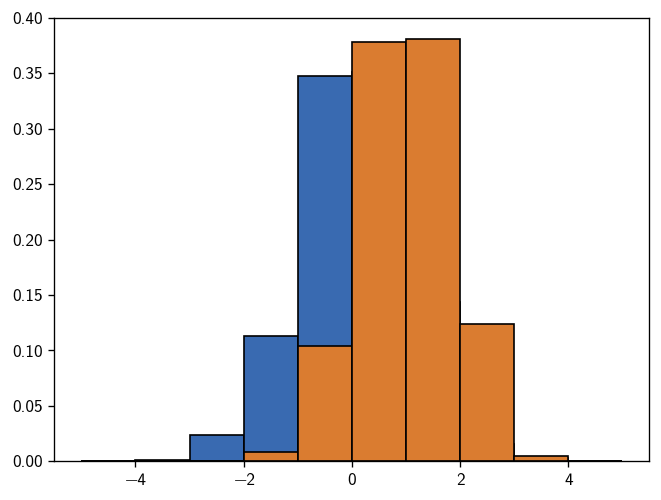

In [22]:
# Compute histograms using NumPy
px, *_ = p(x, range=(-5, 5), bins=10)
py, e, emids = p(y, range=(-5, 5), bins=10)
de = e[1] - e[0]
plt.bar(emids, px, width=de, edgecolor="k")
plt.bar(emids, py, width=de, edgecolor="k")

In [23]:
%timeit _ = p(x, range=(-5, 5), bins=10)

123 μs ± 491 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


<BarContainer object of 10 artists>

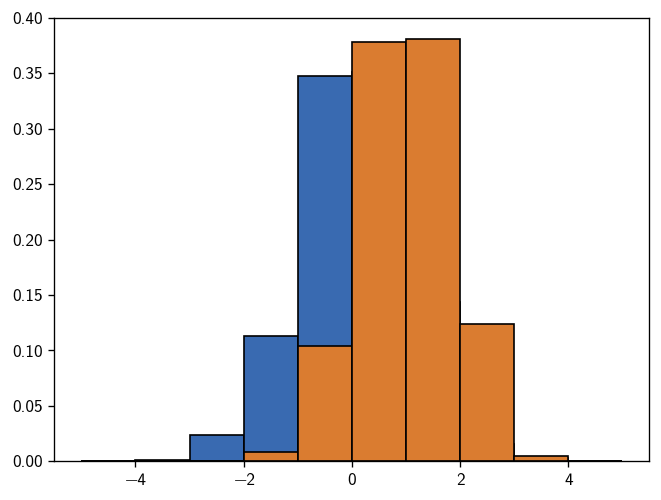

In [24]:
# Compute histograms using cython functions
edges = np.linspace(-5, 5, 11)
cpx = c_histogram(x, edges)
cpx = np.true_divide(cpx, np.sum(cpx))
cpy = c_histogram(y, edges)
cpy = np.true_divide(cpy, np.sum(cpy))
emids = (edges[1:] + edges[:-1]) / 2
de = edges[1] - edges[0]
plt.bar(emids, cpx, width=de, edgecolor="k")
plt.bar(emids, cpy, width=de, edgecolor="k")

In [25]:
%timeit _ = c_histogram(x, edges)

16.5 μs ± 2.23 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Text(0, 0.5, '$y$')

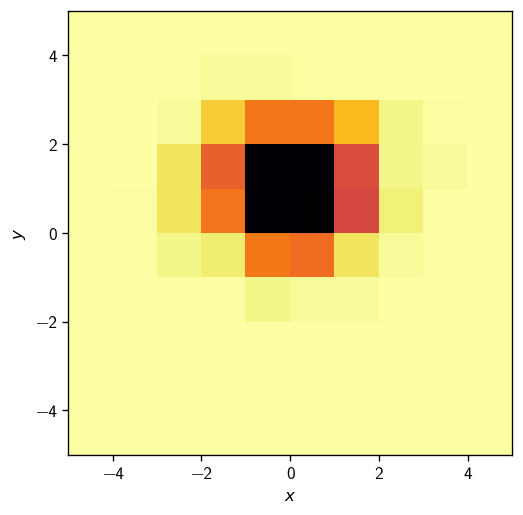

In [26]:
# Compute 2D histogram using NumPy
pxy_counts, ex, ey = p_joint(x, y, range=[(-5, 5), (-5, 5)], bins=[10, 10], weights=None) 
pxy = np.true_divide(pxy_counts, np.sum(pxy_counts))
plt.imshow(pxy.T, extent=[ex[0], ex[-1], ey[0], ey[-1]], cmap=mpl.cm.inferno_r, origin="lower")
plt.xlabel("$x$")
plt.ylabel("$y$")

In [27]:
%timeit _ = p_joint(x, y, range=[(-5, 5), (-5, 5)], bins=[10, 10])

199 μs ± 19.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Text(0, 0.5, '$y$')

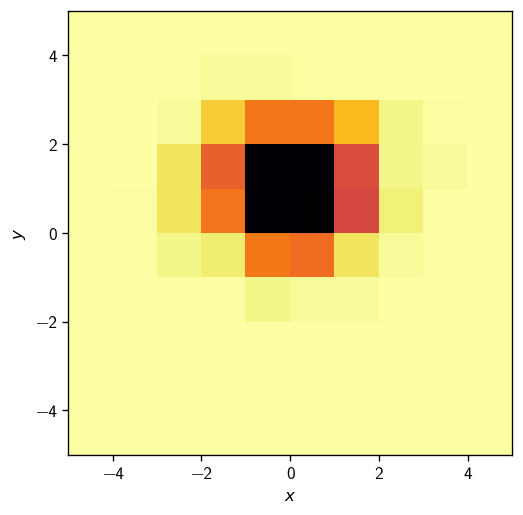

In [28]:
# Compute 2D histogram using cython functions
edges = np.linspace(-5, 5, 11)
cpxy = c_histogramdd(xy, edges) 
cpxy = np.true_divide(cpxy, np.sum(cpxy))
plt.imshow(
    cpxy.reshape(10, 10).T,
    extent=[edges[0],
    edges[-1], edges[0], edges[-1]],
    cmap=mpl.cm.inferno_r, origin="lower"
)
plt.xlabel("$x$")
plt.ylabel("$y$")

In [29]:
%timeit _ = c_histogramdd(xy, edges)

55.4 μs ± 66.3 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Text(0, 0.5, '$y$')

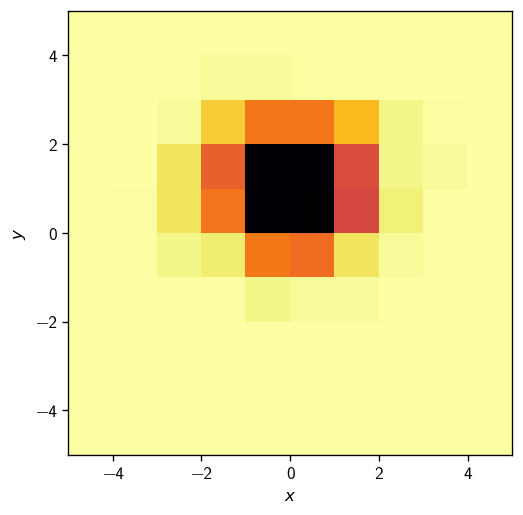

In [30]:
# Compute joint histogram using cython functions (joint)
edges = np.linspace(-5, 5, 11)
cpxy_joint = c_histogramdd_joint(x_, y_, edges) 
cpxy_joint = np.true_divide(cpxy_joint, np.sum(cpxy_joint))
plt.imshow(
    cpxy_joint.reshape(10, 10).T,
    extent=[edges[0],
    edges[-1], edges[0], edges[-1]],
    cmap=mpl.cm.inferno_r, origin="lower"
)
plt.xlabel("$x$")
plt.ylabel("$y$")

In [31]:
%timeit _ = c_histogramdd_joint(x_, y_, edges)

44.3 μs ± 93 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Text(0, 0.5, '$y$')

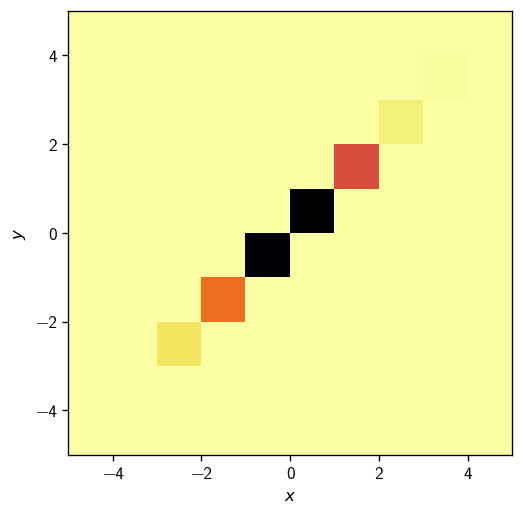

In [32]:
pxx, ex, ey = p_joint(x, x, range=[(-5, 5), (-5, 5)], bins=[10, 10]) 
plt.imshow(pxx.T, extent=[ex[0], ex[-1], ey[0], ey[-1]], cmap=mpl.cm.inferno_r, origin="lower")
plt.xlabel("$x$")
plt.ylabel("$y$")

##### Checks

In [33]:
cpx_from_joint = np.asarray(compute_marginal_x(cpxy_joint))
cpy_from_joint = np.asarray(compute_marginal_y(cpxy_joint))

In [34]:
print(np.allclose(px, cpx, rtol=1e-18))
print(np.allclose(py, cpy, rtol=1e-18))
print(np.allclose(pxy, cpxy.reshape(10, 10), rtol=1e-18))
print(np.allclose(pxy, cpxy_joint.reshape(10, 10), rtol=1e-18))
print(np.allclose(px, cpx_from_joint, rtol=1e-18))
print(np.allclose(py, cpy_from_joint, rtol=1e-18))

True
True
True
True
True
True


In [35]:
%timeit _ = compute_marginal_x(cpxy_joint)

1.19 μs ± 4.1 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [36]:
for row in pxy:
    print(*(f"{element:4.2f}" for element in row), sep="  ")

0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
0.00  0.00  0.00  0.00  0.00  0.01  0.01  0.00  0.00  0.00
0.00  0.00  0.00  0.00  0.01  0.04  0.05  0.02  0.00  0.00
0.00  0.00  0.00  0.00  0.04  0.13  0.13  0.04  0.00  0.00
0.00  0.00  0.00  0.00  0.04  0.13  0.13  0.04  0.00  0.00
0.00  0.00  0.00  0.00  0.01  0.06  0.06  0.02  0.00  0.00
0.00  0.00  0.00  0.00  0.00  0.01  0.00  0.00  0.00  0.00
0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00


##### Entropy

In [39]:
scipy.stats.entropy(px)

np.float64(1.4402743645804708)

In [40]:
min(scipy.stats.entropy(px), scipy.stats.entropy(py))

np.float64(1.2947444215733235)

In [41]:
shannon_entropy(px)

np.float64(1.4402743645804712)

In [42]:
min(shannon_entropy(px), shannon_entropy(py))

np.float64(1.2947444215733235)

In [43]:
c_shannon_entropy(px)

1.4402743645804712

In [44]:
%timeit scipy.stats.entropy(px)

307 μs ± 21.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [45]:
%timeit shannon_entropy(px)

4.65 μs ± 37.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [46]:
%timeit c_shannon_entropy(px)

341 ns ± 2.35 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


##### Mutual information

In [47]:
# Sklearn (needs unnormalised bin counts)
mutual_info_score(labels_true=None, labels_pred=None, contingency=pxy_counts)

0.01306015560052112

In [48]:
mutual_information(px, py, pxy, norm=False)

np.float64(0.013060155600520101)

In [49]:
mutual_information(px, py, pxy, norm=True)

np.float64(0.010087052998961682)

In [50]:
mutual_information(py, px, pxy.T, norm=False)

np.float64(0.013060155600520101)

In [51]:
mutual_information(py, px, pxy.T, norm=True)

np.float64(0.010087052998961682)

In [52]:
mutual_information(px, px, pxx)

np.float64(1.0)

In [53]:
c_norm_mutual_information(px, py, np.asarray(pxy, order="c"))

0.01008705299896168

In [54]:
c_norm_mutual_information(cpx, cpy, np.asarray(cpxy.reshape(10, 10), order="c"))

0.010087052998962842

In [55]:
c_norm_mutual_information(cpx, cpy, cpxy_joint)

0.010087052998962842

In [56]:
c_norm_mutual_information(px, px, np.asarray(pxx, order="c"))

1.0

In [57]:
%timeit mutual_information(px, py, pxy, norm=True)

67 μs ± 286 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [58]:
%timeit c_norm_mutual_information(px, py, pxy)

1.45 μs ± 199 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


#### Coin flip

In [59]:
coin_px = np.array([0.5, 0.5])
coin_py = np.array([0.5, 0.5])
coin_pxy_independent = np.array([[0.25, 0.25], [0.25, 0.25]])
coin_pxy_dependent = np.array([[0.5, 0.], [0., 0.5]])

In [60]:
mutual_information(coin_px, coin_py, coin_pxy_independent)

np.float64(0.0)

In [61]:
mutual_information(coin_px, coin_py, coin_pxy_dependent)

np.float64(1.0)

In [62]:
c_norm_mutual_information(coin_px, coin_py, coin_pxy_independent)

0.0

In [63]:
c_norm_mutual_information(coin_px, coin_py, coin_pxy_dependent)

1.0

## Calculation

### Feature preparation

For the analysis we need our features in form of 2D NumPy array of shape (#frames, #features). We also need a list of feature IDs of length #features. The Cython functions need this array in C-order and of type float.

In [35]:
features = np.load("../../../data/dihedral_angle_features.npy")
with open("../../../data/dihedral_angle_feature_ids.dat") as fp:
    feature_ids = fp.read().splitlines()

In [36]:
features.shape

(2000, 493)

In [37]:
len(feature_ids)

493

In [38]:
feature_ids[:10]

['phi-CYS256',
 'phi-PRO257',
 'phi-TRP258',
 'phi-GLU259',
 'phi-TRP260',
 'phi-THR261',
 'phi-PHE262',
 'phi-PHE263',
 'phi-GLN264',
 'phi-GLY265']

### Validation

In [39]:
fx = features[:, feature_ids.index(f"phi-MET270")]
fy = features[:, feature_ids.index(f"psi-MET270")]

px, *_ = p(fx)
py, *_ = p(fy)
pxy, ex, ey = p_joint(fx, fy)

Text(0.5, 0, 'angle / rad')

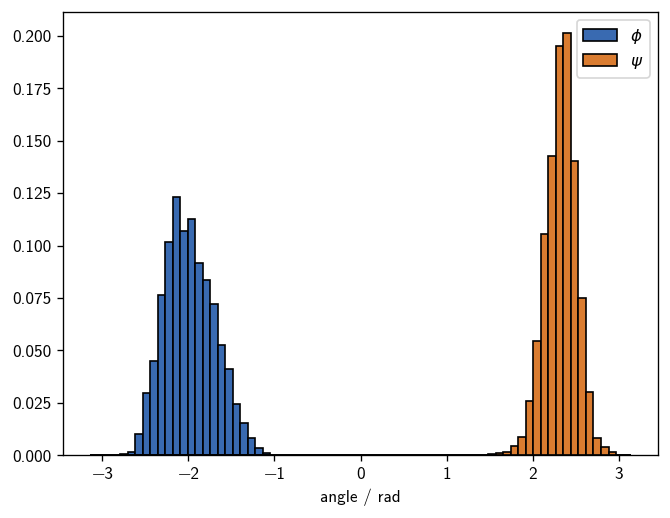

In [40]:
emids = (ex[1:] + ex[:-1]) / 2
de = ex[1] - ex[0]
plt.bar(emids, px, width=de, edgecolor="k")
plt.bar(emids, py, width=de, edgecolor="k")
plt.legend(["$\phi$", "$\psi$"])
plt.xlabel("angle / rad")

Text(0, 0.5, '$\\psi$')

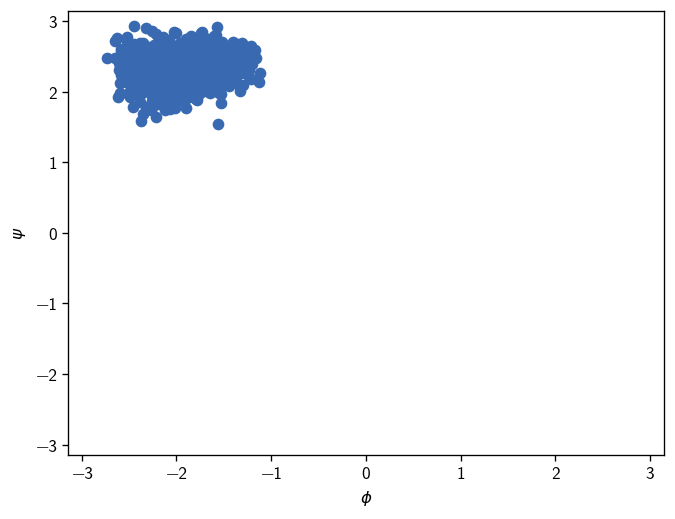

In [41]:
plt.scatter(fx, fy)
plt.xlim((-np.pi, np.pi))
plt.ylim((-np.pi, np.pi))
plt.xlabel("$\phi$")
plt.ylabel("$\psi$")

Text(0, 0.5, '$\\psi$')

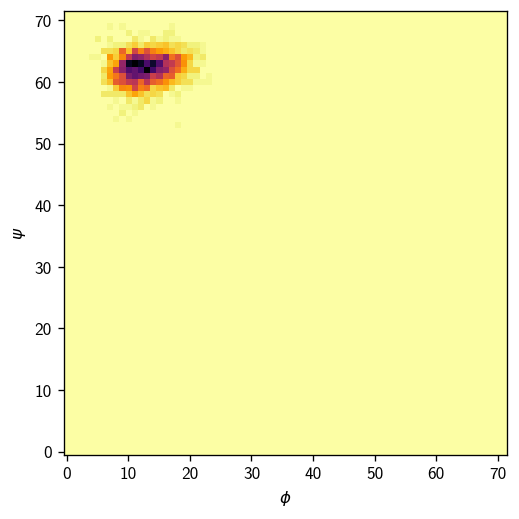

In [42]:
plt.imshow(pxy.T, cmap=mpl.cm.inferno_r, origin="lower")
plt.xlabel("$\phi$")
plt.ylabel("$\psi$")

/tmp/ipykernel_171061/1166145298.py:3: RuntimeWarning: divide by zero encountered in log
  pxy_ = -np.log(pxy_)


Text(0, 0.5, '$\\psi$')

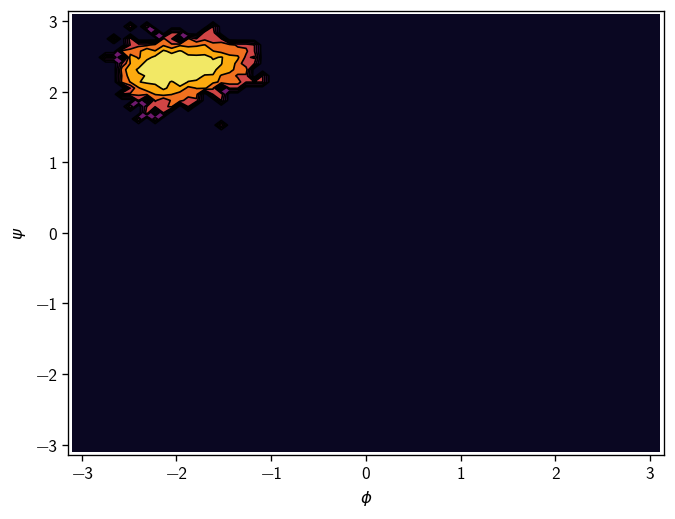

In [44]:
pxy_ = pxy.T
# pxy_[pxy_ == 0] = np.nan
pxy_ = -np.log(pxy_)
pxy_ -= np.min(pxy_)
pxy_[pxy_ > 8] = 8

plt.contourf(
    *np.meshgrid(emids, emids), pxy_, cmap=mpl.cm.inferno_r,
    levels=range(9)
)
plt.contour(
    *np.meshgrid(emids, emids), pxy_, colors="k",
    linewidths=1,
    levels=range(9)
)
plt.xlim((-np.pi, np.pi))
plt.ylim((-np.pi, np.pi))
plt.xlabel("$\phi$")
plt.ylabel("$\psi$")

In [45]:
fx = features[:, feature_ids.index(f"phi-MET270")]
fy = features[:, feature_ids.index(f"psi-MET270")]

fxy = np.asarray(np.vstack([fx, fy]).T, order="c", dtype=np.float64)

edges = np.linspace(-np.pi, np.pi, 73)
pxy = c_histogramdd(fxy, edges)

/tmp/ipykernel_171061/439896059.py:3: RuntimeWarning: divide by zero encountered in log
  pxy_ = -np.log(pxy_)


Text(0, 0.5, '$\\psi$')

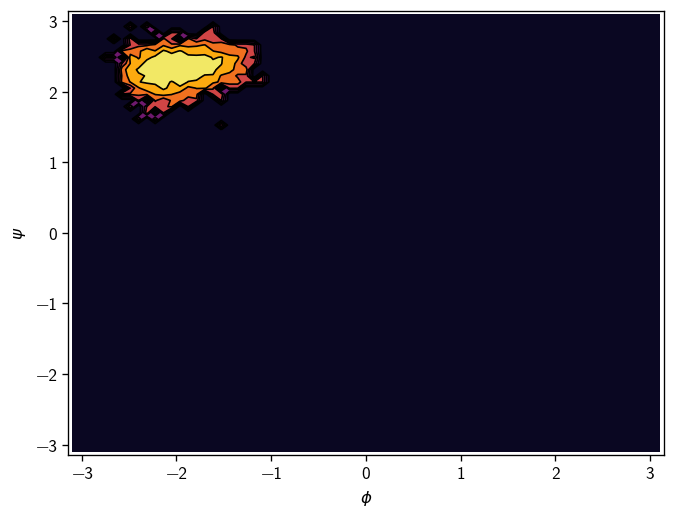

In [46]:
pxy_ = np.array(pxy).reshape(72, 72).T
# pxy_[pxy_ == 0] = np.nan
pxy_ = -np.log(pxy_)
pxy_ -= np.min(pxy_)
pxy_[pxy_ > 8] = 8

plt.contourf(
    *np.meshgrid(emids, emids), pxy_, cmap=mpl.cm.inferno_r,
    levels=range(9)
)
plt.contour(
    *np.meshgrid(emids, emids), pxy_, colors="k",
    linewidths=1,
    levels=range(9)
)
plt.xlim((-np.pi, np.pi))
plt.ylim((-np.pi, np.pi))
plt.xlabel("$\phi$")
plt.ylabel("$\psi$")

### Mutual information

#### Single features only (a)

In [396]:
feature_list_a, feature_list_ids_a = prepare_feature_list(
    [
        (("phi",), "phi"),
        (("psi",), "psi"),
        (("chi1",), "chi1"),
        (("chi2",), "chi2"),
        (("chi3",), "chi3"),
        (("chi4",), "chi4"),
    ]
)

  0%|          | 0/126 [00:00<?, ?it/s]

In [397]:
feature_list_a

[array([[-2.09717083],
        [-2.51465893],
        [-2.41536188],
        ...,
        [-1.66678071],
        [-1.78260243],
        [-2.3815186 ]]),
 array([[2.91984415],
        [2.81241274],
        [2.8270154 ],
        ...,
        [2.73945522],
        [2.877666  ],
        [2.77284431]]),
 array([[-1.03595495],
        [-1.03238928],
        [-1.00734293],
        ...,
        [-0.98095912],
        [-0.88825738],
        [-0.88630068]]),
 array([[-1.19502151],
        [-1.0890913 ],
        [-1.21805513],
        ...,
        [-1.01709235],
        [-1.05454147],
        [-1.08526015]]),
 array([[-3.13400817],
        [ 2.90698385],
        [ 3.0050261 ],
        ...,
        [ 2.91223431],
        [ 2.82944727],
        [ 2.94415522]]),
 array([[-0.20310095],
        [-0.35475805],
        [ 0.5206337 ],
        ...,
        [-0.19056475],
        [-0.34668401],
        [ 0.50073868]]),
 array([[ 0.42757237],
        [ 0.60310841],
        [-0.51806074],
        ...,
      

In [320]:
# Compute mutual information (cythonized alternative bellow)

n_features = len(feature_list)
nmi_matrix_a = np.eye(n_features)
edges = np.linspace(-np.pi, np.pi, 73, dtype=np.float64)

for xi, fx in enumerate(tqdm(feature_list)):
    for yi, fy in enumerate(feature_list[xi + 1:], xi + 1):

        # NumPy only
        # px, *_ = p(fx.T[0])
        # py, *_ = p(fy.T[0])
        # pxy, *_ = p_joint(fx.T[0], fy.T[0])
        
        pxy = c_histogramdd_joint(fx, fy, edges)
        c_norm_pxy_fixed(pxy, fx.shape[0])
        px = compute_marginal_x(pxy)
        py = compute_marginal_y(pxy)
        
        nmi_matrix_a[xi, yi] = c_norm_mutual_information(px, py, pxy)

  0%|          | 0/489 [00:00<?, ?it/s]

In [255]:
# No further speedup though (bottleneck is conversion of features to memoryviews)
nmi_matrix_a = np.asarray(compute_nmi_matrix_from_feature_list(feature_list_a))

In [328]:
nmi_matrix_a.max()

1.0

In [329]:
print(nmi_matrix_a[nmi_matrix_a < 1].max())
print(nmi_matrix_a[nmi_matrix_a > 0].min())

0.4442034791237605
0.0001454864142591235


In [336]:
nmi_matrix_a

array([[1.        , 0.00780633, 0.00824839, ..., 0.0037422 , 0.00508558,
        0.01582287],
       [0.        , 1.        , 0.00616602, ..., 0.00260874, 0.00114418,
        0.00751699],
       [0.        , 0.        , 1.        , ..., 0.00471988, 0.00478114,
        0.0119207 ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.00479582,
        0.02166522],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.01089562],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [445]:
G_a = nmi_matrix_to_graph(nmi_matrix_a, feature_list_ids_a)

In [446]:
networkx.readwrite.gml.write_gml(G_a, "phi_psi_chi.gml")

#### Backbone as 2D feature (b)

In [403]:
feature_list_b, feature_list_ids_b = prepare_feature_list(
    [
        (("phi", "psi"), "bb"),
        (("chi1",), "chi1")
    ]
)

  0%|          | 0/126 [00:00<?, ?it/s]

In [405]:
feature_list_ids_b

['bb_256',
 'chi1_256',
 'bb_257',
 'chi1_257',
 'bb_258',
 'chi1_258',
 'bb_259',
 'chi1_259',
 'bb_260',
 'chi1_260',
 'bb_261',
 'chi1_261',
 'bb_262',
 'chi1_262',
 'bb_263',
 'chi1_263',
 'bb_264',
 'chi1_264',
 'bb_265',
 'bb_266',
 'chi1_266',
 'bb_267',
 'chi1_267',
 'bb_268',
 'chi1_268',
 'bb_269',
 'chi1_269',
 'bb_270',
 'chi1_270',
 'bb_271',
 'chi1_271',
 'bb_272',
 'chi1_272',
 'bb_273',
 'chi1_273',
 'bb_274',
 'chi1_274',
 'bb_275',
 'chi1_275',
 'bb_276',
 'chi1_276',
 'bb_277',
 'chi1_277',
 'bb_278',
 'chi1_278',
 'bb_279',
 'chi1_279',
 'bb_280',
 'chi1_280',
 'bb_281',
 'chi1_281',
 'bb_282',
 'chi1_282',
 'bb_283',
 'bb_284',
 'chi1_284',
 'bb_285',
 'chi1_285',
 'bb_286',
 'chi1_286',
 'bb_287',
 'chi1_287',
 'bb_288',
 'bb_289',
 'bb_290',
 'chi1_290',
 'bb_291',
 'chi1_291',
 'bb_292',
 'chi1_292',
 'bb_293',
 'chi1_293',
 'bb_294',
 'chi1_294',
 'bb_295',
 'chi1_295',
 'bb_296',
 'chi1_296',
 'bb_297',
 'bb_298',
 'chi1_298',
 'bb_299',
 'chi1_299',
 'bb_300'

In [272]:
nmi_matrix_b = np.asarray(compute_nmi_matrix_from_feature_list(feature_list_b))

In [407]:
nmi_matrix_b.max()

1.0

In [408]:
print(nmi_matrix_b[nmi_matrix_b < 1].max())
print(nmi_matrix_b[nmi_matrix_b > 0].min())

0.2537015136839204
0.0001850924089682497


In [447]:
G_b = nmi_matrix_to_graph(nmi_matrix_b, feature_list_ids_b)

In [448]:
networkx.readwrite.gml.write_gml(G_b, "bb_chi1.gml")

#### All $\chi$-angles (c)

In [466]:
feature_list_c, feature_list_ids_c = prepare_feature_list(
    [
        (("phi", "psi"), "bb"),
        (("chi1",), "chi1"),
        (("chi2",), "chi2"),
        (("chi3",), "chi3"),
        (("chi4",), "chi4")
    ]
)

  0%|          | 0/126 [00:00<?, ?it/s]

In [467]:
feature_list_ids_c

['bb_256',
 'chi1_256',
 'bb_257',
 'chi1_257',
 'chi2_257',
 'bb_258',
 'chi1_258',
 'chi2_258',
 'bb_259',
 'chi1_259',
 'chi2_259',
 'chi3_259',
 'bb_260',
 'chi1_260',
 'chi2_260',
 'bb_261',
 'chi1_261',
 'bb_262',
 'chi1_262',
 'chi2_262',
 'bb_263',
 'chi1_263',
 'chi2_263',
 'bb_264',
 'chi1_264',
 'chi2_264',
 'chi3_264',
 'bb_265',
 'bb_266',
 'chi1_266',
 'chi2_266',
 'bb_267',
 'chi1_267',
 'bb_268',
 'chi1_268',
 'chi2_268',
 'bb_269',
 'chi1_269',
 'chi2_269',
 'bb_270',
 'chi1_270',
 'chi2_270',
 'chi3_270',
 'bb_271',
 'chi1_271',
 'bb_272',
 'chi1_272',
 'chi2_272',
 'bb_273',
 'chi1_273',
 'bb_274',
 'chi1_274',
 'chi2_274',
 'chi3_274',
 'bb_275',
 'chi1_275',
 'chi2_275',
 'chi3_275',
 'chi4_275',
 'bb_276',
 'chi1_276',
 'chi2_276',
 'bb_277',
 'chi1_277',
 'chi2_277',
 'bb_278',
 'chi1_278',
 'chi2_278',
 'bb_279',
 'chi1_279',
 'chi2_279',
 'bb_280',
 'chi1_280',
 'bb_281',
 'chi1_281',
 'chi2_281',
 'bb_282',
 'chi1_282',
 'bb_283',
 'bb_284',
 'chi1_284',
 'bb_

In [471]:
nmi_matrix_c = np.asarray(compute_nmi_matrix_from_feature_list(feature_list_c))

In [475]:
nmi_matrix_c.max()

1.0

In [483]:
print(nmi_matrix_c[nmi_matrix_c < 1].max())
print(nmi_matrix_c[nmi_matrix_c > 0].min())

0.4442034791237605
0.0001850924089682497


In [473]:
G_c = nmi_matrix_to_graph(nmi_matrix_c, feature_list_ids_c)

In [474]:
networkx.readwrite.gml.write_gml(G_c, "bb_chi.gml")

#### Plots

In [482]:
nmi_matrix_c

array([[1.        , 0.02312152, 0.03207323, ..., 0.03421582, 0.01768372,
        0.09257524],
       [0.        , 1.        , 0.02387271, ..., 0.01057703, 0.00471988,
        0.03650008],
       [0.        , 0.        , 1.        , ..., 0.01899049, 0.00749239,
        0.05330619],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.01781726,
        0.09113529],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.05426828],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [477]:
G_c.edges

MultiEdgeView([('256', '256', 0), ('256', '257', 0), ('256', '257', 1), ('256', '257', 2), ('256', '257', 3), ('256', '257', 4), ('256', '257', 5), ('256', '258', 0), ('256', '258', 1), ('256', '258', 2), ('256', '258', 3), ('256', '258', 4), ('256', '258', 5), ('256', '259', 0), ('256', '259', 1), ('256', '259', 2), ('256', '259', 3), ('256', '259', 4), ('256', '259', 5), ('256', '259', 6), ('256', '259', 7), ('256', '260', 0), ('256', '260', 1), ('256', '260', 2), ('256', '260', 3), ('256', '260', 4), ('256', '260', 5), ('256', '261', 0), ('256', '261', 1), ('256', '261', 2), ('256', '261', 3), ('256', '262', 0), ('256', '262', 1), ('256', '262', 2), ('256', '262', 3), ('256', '262', 4), ('256', '262', 5), ('256', '263', 0), ('256', '263', 1), ('256', '263', 2), ('256', '263', 3), ('256', '263', 4), ('256', '263', 5), ('256', '264', 0), ('256', '264', 1), ('256', '264', 2), ('256', '264', 3), ('256', '264', 4), ('256', '264', 5), ('256', '264', 6), ('256', '264', 7), ('256', '265', 0

In [479]:
G_c = networkx.readwrite.gml.read_gml("bb_chi.gml")
nmi_matrix_c = graph_to_nmi_matrix(G_c, feature_list_ids_c)

In [527]:
tril = np.tril_indices_from(nmi_matrix_c)
nmi_matrix_c[tril] = nmi_matrix_c.T[tril]

In [480]:
for a, b, d in G_c.edges(data=True):
    print(a, b, d["nmi"])

256 256 0.023121519710241206
256 257 0.032073227760152444
256 257 0.028525217453819775
256 257 0.027999896260638747
256 257 0.023872706401406863
256 257 0.0028887366443238814
256 257 0.0029159282959093013
256 258 0.047165869621837275
256 258 0.0221998381202992
256 258 0.020471656272883432
256 258 0.024380650416699665
256 258 0.00440298876498882
256 258 0.004208551038694373
256 259 0.03339807025447333
256 259 0.015408919724401473
256 259 0.015898894026450627
256 259 0.017627821355405734
256 259 0.01217554827859527
256 259 0.003057175767606997
256 259 0.003030051848141398
256 259 0.0038522113881794867
256 260 0.04534989023726755
256 260 0.010457758911645252
256 260 0.02348556469795346
256 260 0.014319438231982186
256 260 0.001450638942740337
256 260 0.012076145998681209
256 261 0.044159799759399654
256 261 0.014832681110532065
256 261 0.023840418442630427
256 261 0.005442786619660512
256 262 0.03153057924117959
256 262 0.015476375678463765
256 262 0.015039539636383941
256 262 0.011852650

257 313 0.0077392573837260625
257 313 0.0007410600430509374
257 313 0.0015282744565150732
257 313 0.008664583181601028
257 313 0.0007804975511671028
257 313 0.0016848288746425055
257 314 0.017450131767871073
257 314 0.007842016533062423
257 314 0.0051575855196277914
257 314 0.0015543714691806023
257 314 0.005581901626181035
257 314 0.001638935983528154
257 315 0.013692563334377872
257 315 0.0030725493860477167
257 315 0.003180124219633477
257 315 0.0037385971678755674
257 315 0.0003013131171001513
257 315 0.0003836373278826178
257 315 0.004159086872022405
257 315 0.00040231139830813347
257 315 0.00041088047703024996
257 316 0.015124363351527878
257 316 0.00670318147835741
257 316 0.007004861925168201
257 316 0.00784973087158762
257 316 0.004138915917789852
257 316 0.0012105125381602383
257 316 0.001052961735449991
257 316 0.001391610356919562
257 316 0.004382496658956599
257 316 0.0012718309435519768
257 316 0.001194671157118137
257 316 0.0015253303473901807
257 317 0.01492109479654805

258 306 0.010912487711992382
258 306 0.0033937074294529026
258 306 0.0038524845569609914
258 306 0.0038477030070371
258 306 0.012602464046598967
258 306 0.0038494502006939852
258 306 0.004445559170717071
258 306 0.0036539439165652224
258 307 0.034723711997638664
258 307 0.01186926439442713
258 307 0.01821501587122299
258 307 0.004465346119851153
258 307 0.02165582058436732
258 307 0.0052949735693827975
258 308 0.029682743783923136
258 308 0.01161671264963541
258 308 0.013738419854578259
258 308 0.003531300142701296
258 308 0.014578319465081866
258 308 0.0044175722920197
258 309 0.037817375615418945
258 309 0.012624453152370986
258 309 0.012122133744614223
258 309 0.011729514911749993
258 309 0.011647763317391917
258 309 0.018139296423104048
258 309 0.003422535498142785
258 309 0.0033869576665016255
258 309 0.0031734836862371257
258 309 0.003502374258298811
258 309 0.0192233415764548
258 309 0.003988106456018804
258 309 0.0041563254413851634
258 309 0.0038103891073254285
258 309 0.00313

259 286 0.0033903751482550182
259 286 0.004283313122925839
259 286 0.0034468090027219333
259 287 0.019960299028760994
259 287 0.007848816208488932
259 287 0.008810113942263297
259 287 0.0023531552519522
259 287 0.009084498400915558
259 287 0.002357670643063146
259 287 0.009779920601287368
259 287 0.003287662484609922
259 288 0.021963035117916845
259 288 0.009832336722679164
259 288 0.010161838722260643
259 288 0.01134249685855675
259 289 0.024561710354118162
259 289 0.010940161534180454
259 289 0.011318984875742302
259 289 0.012548822046917369
259 290 0.02222485127847625
259 290 0.009493094471291458
259 290 0.01023327515382202
259 290 0.010625934759623248
259 290 0.009783515266002433
259 290 0.0027669997313430135
259 290 0.002865651002261851
259 290 0.0034520473261842356
259 290 0.010200875481974495
259 290 0.0029742979280464325
259 290 0.0029809185940541517
259 290 0.003609349244960028
259 290 0.010846232640493177
259 290 0.0033427064752315078
259 290 0.0037162802268969346
259 290 0.0

259 374 0.014907552300188743
259 374 0.004778372605326401
259 374 0.008098296226900574
259 374 0.005393799509589466
259 374 0.0013057869894911793
259 374 0.0023660115580854185
259 374 0.005565387270839497
259 374 0.0012600195741960878
259 374 0.002749576105024923
259 374 0.0063152622444340315
259 374 0.0015607480620291824
259 374 0.002998537954945945
259 375 0.01733697626270979
259 375 0.0038351634337239035
259 375 0.0040982096742835285
259 375 0.006998954262475682
259 375 0.0009037152824759286
259 375 0.0009922493882727774
259 375 0.007212682174906097
259 375 0.0009947850263737454
259 375 0.0011416301480785106
259 375 0.007663056645885244
259 375 0.001202175380453681
259 375 0.001178621616527972
259 376 0.016795155230228367
259 376 0.008446547637540368
259 376 0.00834478086385282
259 376 0.006864117941285103
259 376 0.002110313923608062
259 376 0.00254679035689659
259 376 0.006986970927780771
259 376 0.0023554427545233745
259 376 0.002562937886328779
259 376 0.007397320796141654
259 3

260 345 0.0022919082153895444
260 345 0.0029685837176169692
260 345 0.002036125861572913
260 346 0.04173527245952117
260 346 0.007227801235582397
260 346 0.011260772102129422
260 347 0.02869500076442043
260 347 0.008174170312135744
260 347 0.009210473954684802
260 347 0.016213483494036306
260 347 0.003298957726807598
260 347 0.0004360877297565159
260 347 0.0006066487916798286
260 347 0.001070897285830019
260 347 0.005787207658066668
260 347 0.0009190172251386053
260 347 0.0012776527443679392
260 347 0.0033597774008651392
260 348 0.028548187236083378
260 348 0.008782716057348209
260 348 0.009126370076303333
260 348 0.003403036945667538
260 348 0.00030289954721091664
260 348 0.0003870010743298274
260 348 0.005531982843670474
260 348 0.0007664523047300465
260 348 0.0007898458556465606
260 349 0.03404670221495654
260 349 0.015074805997508944
260 349 0.016533929159898715
260 349 0.004257759075736699
260 349 0.0009696662320540718
260 349 0.0010627349838241975
260 349 0.007391808481661394
260

261 355 0.008721306539204046
261 355 0.0011067106332853618
261 355 0.0013596450522542379
261 356 0.027514312363919442
261 356 0.005782388039361632
261 356 0.008019634260982159
261 356 0.0009931175352857241
261 357 0.030988375327977838
261 357 0.009590463858427805
261 358 0.03755145146603507
261 358 0.012191247630242008
261 358 0.01110394789992348
261 358 0.017171784299115353
261 358 0.013081384979858203
261 358 0.003619268928465363
261 358 0.0025531393106373933
261 358 0.004781084087316291
261 359 0.0460749546772958
261 359 0.011391281103968974
261 359 0.015249687645797337
261 359 0.01831484592136058
261 359 0.0031882814434736825
261 359 0.0046119963159715815
261 360 0.0689939421561488
261 360 0.015752292023875156
261 360 0.03005854149195387
261 360 0.003970971529329125
261 361 0.07899231034223869
261 361 0.0372775316369101
261 362 0.07433929265217828
261 362 0.01490336472672927
261 362 0.015912367651595448
261 362 0.029382037329224734
261 362 0.002759687522972578
261 362 0.00325222703

262 340 0.0090274963684307
262 340 0.010274055093054367
262 340 0.010300977768238139
262 340 0.010375501810751753
262 340 0.014855925265485907
262 340 0.00672811755317858
262 340 0.0023591144723390397
262 340 0.0034654374587979233
262 340 0.0027655966281748263
262 340 0.014203924900294035
262 340 0.00278602957267773
262 340 0.0029007864323762848
262 340 0.0025335112992545578
262 340 0.002532325757791739
262 341 0.034373378838349775
262 341 0.00931998834281707
262 341 0.009181507424942217
262 341 0.009187990572900394
262 341 0.013859586507159861
262 341 0.003776601855695456
262 341 0.0035823272860315155
262 341 0.003417846326000202
262 341 0.014503035775856056
262 341 0.0028271542095911167
262 341 0.003007652576885651
262 341 0.002827281017312343
262 342 0.02299120812803682
262 342 0.0046409071662326514
262 342 0.009099432918836236
262 342 0.009903015655003157
262 342 0.001028528256251211
262 342 0.0038677355027913925
262 342 0.009379018927013701
262 342 0.0012792544740166418
262 342 0.

263 316 0.0011724979298426556
263 316 0.001526984012155268
263 316 0.003874298990593604
263 316 0.0011460500930298206
263 316 0.001037095269656384
263 316 0.0015489275371443083
263 317 0.013184989252127195
263 317 0.003909544728349437
263 317 0.003899999898608537
263 318 0.01244296700626727
263 318 0.004128588476998595
263 318 0.004876299865611444
263 318 0.003443475280376714
263 318 0.000550079890737908
263 318 0.0007292270181493887
263 318 0.003699277517711927
263 318 0.0006257982680423247
263 318 0.000794330450586658
263 319 0.010055493675657673
263 319 0.004305389135162711
263 319 0.002819283921493905
263 319 0.0009285639305853888
263 319 0.0029685070546151622
263 319 0.0009183357868248605
263 320 0.0140322456943193
263 320 0.0028144342554517333
263 320 0.00627496584862801
263 320 0.004923942001588879
263 320 0.00042566703111119984
263 320 0.0012930634437456488
263 320 0.0050858450349203265
263 320 0.00040234012894920743
263 320 0.0012703669981780584
263 321 0.01750656728241781
263

264 303 0.0030294878337817884
264 303 0.005992531565935632
264 303 0.002447470303125117
264 303 0.00315129273539904
264 304 0.01717693521537303
264 304 0.010703927477711582
264 304 0.011546725455125726
264 304 0.012858718564723032
264 304 0.004543265050844138
264 304 0.0019384356029213863
264 304 0.0020045889099629044
264 304 0.002821646150972257
264 304 0.005383190927290884
264 304 0.0023647319161587024
264 304 0.0030691689077807422
264 304 0.003899790288099528
264 304 0.006089795243447304
264 304 0.0028261780692438966
264 304 0.003213249241288079
264 304 0.0035052049611614855
264 305 0.020009944497789565
264 305 0.010486393435574367
264 305 0.011629011560154605
264 305 0.005873297230220535
264 305 0.002280609776155267
264 305 0.0023859893300342745
264 305 0.006638923384827976
264 305 0.002636967355371905
264 305 0.0029131128780375297
264 305 0.007648125338540238
264 305 0.002677520086643846
264 305 0.002989836470133068
264 306 0.024519220093293055
264 306 0.010908797673251832
264 306

265 299 0.01984399724343183
265 299 0.013137657840466641
265 299 0.008060665878577417
265 299 0.01726803757634747
265 300 0.020062842588894274
265 300 0.011678561126533482
265 300 0.014068143150106299
265 300 0.015810024523504544
265 301 0.02231100406143468
265 301 0.011483597046950716
265 301 0.016122439137385036
265 302 0.02147059008785656
265 302 0.008926527490659147
265 302 0.008651484838462451
265 303 0.02039413959101625
265 303 0.010538605211206609
265 303 0.0123864952881295
265 304 0.020170037020208795
265 304 0.012533360926494675
265 304 0.013910648792074634
265 304 0.015616430823769215
265 305 0.023279364693668477
265 305 0.01278059025923212
265 305 0.013936618184327822
265 306 0.027828528742373376
265 306 0.013335409260510422
265 306 0.015898498435948347
265 306 0.015790061116222436
265 307 0.03755016149774065
265 307 0.014113514492009552
265 308 0.03314265516937923
265 308 0.014163857667107857
265 309 0.041510971513078386
265 309 0.014112199698305442
265 309 0.01506445892065

266 353 0.0023886207360852003
266 353 0.010821907971113418
266 353 0.0028399482703363294
266 353 0.002552662395972409
266 353 0.004109370569920417
266 354 0.025529326223032042
266 354 0.00410574479645058
266 354 0.004101066792962072
266 354 0.007822659416398588
266 354 0.008495051309129543
266 354 0.0007653841984146163
266 354 0.0007299177720980182
266 354 0.001843700857128675
266 354 0.013171227091417739
266 354 0.0013469578951215045
266 354 0.0012994595055546242
266 354 0.003295634208090232
266 355 0.015794016067589272
266 355 0.003317704456412789
266 355 0.0043577320992951385
266 355 0.005371340916179196
266 355 0.0005610598035751754
266 355 0.0008003064619178609
266 355 0.008050725340354982
266 355 0.0010438543881057469
266 355 0.0013166168702461634
266 356 0.015129963001377623
266 356 0.002987150126340913
266 356 0.0050585333667619034
266 356 0.0005632419879394977
266 356 0.007774705531681532
266 356 0.0009284648055460493
266 357 0.017874626302778814
266 357 0.006045625143527501
2

268 278 0.003389083661222578
268 278 0.0009172330126343769
268 278 0.0012005563756449528
268 279 0.016546404524787797
268 279 0.005569398236745936
268 279 0.007985671105118365
268 279 0.0034952428071328093
268 279 0.0004498510827020349
268 279 0.0011653235613855672
268 279 0.003764858575477149
268 279 0.0006283426636841002
268 279 0.0012610919565025757
268 280 0.01227804076644907
268 280 0.005372492188027439
268 280 0.002386115724405898
268 280 0.0005553513330506519
268 280 0.0025794577229044323
268 280 0.0005355017630405259
268 281 0.012885742817025501
268 281 0.006843257204561231
268 281 0.00753303372269724
268 281 0.002880557139197668
268 281 0.0011501230740534954
268 281 0.000992979281807866
268 281 0.00278526964837913
268 281 0.000992151154555162
268 281 0.0009485424526189386
268 282 0.014052613691074673
268 282 0.005674579815577077
268 282 0.003245996129123374
268 282 0.0007627429326678638
268 282 0.0033250804907263335
268 282 0.0007584904285989356
268 283 0.013362221282852554
26

269 285 0.004939207232840694
269 285 0.0019384322803340385
269 285 0.002289829384677907
269 285 0.0022965418486189074
269 285 0.0023374221785310424
269 286 0.02293979715864085
269 286 0.011428743265594258
269 286 0.012618750981361235
269 286 0.013819737936846713
269 286 0.006028904222906157
269 286 0.0023711405880159943
269 286 0.00188300104219277
269 286 0.002937946916021937
269 286 0.007100610947680293
269 286 0.0022874826348737065
269 286 0.0024908058357483807
269 286 0.002969085906755751
269 287 0.023947737041564793
269 287 0.009380351775995532
269 287 0.006322999151489466
269 287 0.001454856173183335
269 287 0.007250184003662893
269 287 0.010603286763813566
269 288 0.025928817726431193
269 288 0.007766761779159607
269 288 0.00840602542999432
269 289 0.027798481831085676
269 289 0.009185773670035015
269 289 0.009143432211701625
269 290 0.02596826001300501
269 290 0.012791082635736199
269 290 0.013032950936482863
269 290 0.013751924420537569
269 290 0.007846543924037813
269 290 0.00

270 298 0.0029879768318465246
270 298 0.0038258640427524886
270 298 0.007317822666519856
270 298 0.0034956212834800797
270 298 0.0031680858030828083
270 298 0.0039436527828006695
270 298 0.0078034632008839415
270 298 0.0037716704477271036
270 298 0.003838430099888726
270 298 0.0037355781256937217
270 299 0.01710453839796146
270 299 0.010319078360158048
270 299 0.005561137775061507
270 299 0.014218430982848036
270 299 0.005164780641837607
270 299 0.002708402679698032
270 299 0.0013473237345854705
270 299 0.0060968811740942565
270 299 0.005582227009025357
270 299 0.0027303417689454774
270 299 0.0012790922492584961
270 299 0.004701681588219368
270 299 0.005748940805684129
270 299 0.0031746431944389636
270 299 0.0013909919282789097
270 299 0.004406688027020499
270 300 0.017251387334809416
270 300 0.010679785696082581
270 300 0.012212430278868994
270 300 0.013257624171207984
270 300 0.00544939286898769
270 300 0.004436012205922523
270 300 0.004454872293894509
270 300 0.005748903546713574
27

271 303 0.001629378929299504
271 304 0.011622719119093426
271 304 0.006890502292873576
271 304 0.008026230707982425
271 304 0.007965284151331528
271 304 0.004399282617304857
271 304 0.0019936087370171457
271 304 0.0018843540742597938
271 304 0.003059426219272225
271 305 0.01381254881520721
271 305 0.0061940836239955345
271 305 0.007549976855524991
271 305 0.005513160052779707
271 305 0.0018300717105029088
271 305 0.0020552191724654938
271 306 0.017900729459193583
271 306 0.007121802092450813
271 306 0.008824533455676745
271 306 0.00814763157247287
271 306 0.007585840522467054
271 306 0.0026348971316340324
271 306 0.00333687497686774
271 306 0.003561376781125343
271 307 0.027383438226777947
271 307 0.007900834266079758
271 307 0.012082872770161564
271 307 0.0021204139196952495
271 308 0.022438535239548557
271 308 0.007603154304974357
271 308 0.009874067079398939
271 308 0.0021459647597647903
271 309 0.028603817024973104
271 309 0.007904838202168621
271 309 0.008513338456219502
271 309 0

272 336 0.01071515626968927
272 336 0.013062372933689418
272 336 0.008946140004359188
272 336 0.0020775482317048864
272 336 0.0028373741022379917
272 336 0.009536998345557697
272 336 0.0025770799370298
272 336 0.003511567359272105
272 337 0.02437096612996753
272 337 0.007716457499264739
272 337 0.008315886424503425
272 337 0.006920116672958627
272 337 0.0012971692982529912
272 337 0.001435343679362922
272 337 0.007426512514477054
272 337 0.0014930566871622344
272 337 0.001603228022914777
272 338 0.03379341886010134
272 338 0.013033226823709368
272 338 0.011314517514993502
272 338 0.002581943835728937
272 338 0.0119666648302043
272 338 0.003367067050476121
272 339 0.040695253200462585
272 339 0.010894331407014622
272 339 0.012524874802029679
272 339 0.014956823467868318
272 339 0.0020397965813438194
272 339 0.0031815786275754955
272 339 0.015974175199574156
272 339 0.0022699460276018797
272 339 0.00328361332689297
272 340 0.043790825776603585
272 340 0.013401703188086318
272 340 0.01538

273 377 0.007998260930758394
273 377 0.0012231071318532074
273 378 0.02411137709305748
273 378 0.009490282985978541
273 378 0.006192821804438833
273 378 0.013771262648391803
273 378 0.006853561412798359
273 378 0.007172169070386504
273 378 0.0024461045006452784
273 378 0.0012342113907409208
273 378 0.0033076697010461548
273 378 0.0015796146324667574
273 379 0.02663942547395238
273 379 0.012909839957497915
273 379 0.009144943797031251
273 379 0.013806887523903175
273 379 0.01525459643100761
273 379 0.00880216073876626
273 379 0.00295002785247487
273 379 0.002305315476432142
273 379 0.003046616005945257
273 379 0.0032168721558649494
273 380 0.030086309974448378
273 380 0.013439998312031683
273 380 0.010967387420598248
273 380 0.002986896993402604
273 381 0.07286736064137757
273 381 0.03317764260286445
274 274 0.010445862788101359
274 274 0.008608660683894667
274 274 0.016249858146610348
274 274 0.009398668460363581
274 274 0.015361260764983358
274 274 0.026968782400274706
274 275 0.08114

274 358 0.0022078796635293797
274 358 0.003609771076868882
274 358 0.011177099573107157
274 358 0.0019682580065163635
274 358 0.0016067227111058022
274 358 0.003429908472059595
274 358 0.015098097610627978
274 358 0.007790534217419289
274 358 0.005752183129909518
274 358 0.005836770217554754
274 359 0.029851121653951956
274 359 0.005605385134559714
274 359 0.007967582191101986
274 359 0.012288972661780135
274 359 0.0022914793634431613
274 359 0.0021492640307397503
274 359 0.014350847346525785
274 359 0.0017461221410123796
274 359 0.0026196654665536657
274 359 0.0202914532091697
274 359 0.006593294481649008
274 359 0.005157317547001675
274 360 0.04703118983658697
274 360 0.008102469455212842
274 360 0.019503020129894293
274 360 0.0019430770775063402
274 360 0.022636336197360288
274 360 0.0027185314447510387
274 360 0.03475062287255477
274 360 0.005890787475691126
274 361 0.055143235308318744
274 361 0.025134080234673693
274 361 0.028142180441987488
274 361 0.042132909325906805
274 362 0

275 306 0.00877380811501477
275 306 0.003007293030126979
275 306 0.004086120305363156
275 306 0.004180826584792028
275 306 0.009476548134195021
275 306 0.0025525067908142526
275 306 0.0033731483402822267
275 306 0.0031572393308611883
275 307 0.022262152875675217
275 307 0.005706828327149435
275 307 0.012323343482320946
275 307 0.0023519661992628563
275 307 0.01266892452880467
275 307 0.002224829415827513
275 307 0.013543398224785593
275 307 0.0038723975803427943
275 307 0.015744633463730142
275 307 0.003207903004894368
275 308 0.017942185227271135
275 308 0.0050992457279633715
275 308 0.009753531727404757
275 308 0.0023245193382983855
275 308 0.010256286799312099
275 308 0.002330835688701489
275 308 0.011167312736813817
275 308 0.0028351096005907236
275 308 0.012152353815223256
275 308 0.0025146479601208184
275 309 0.023009066780400985
275 309 0.0050943792354566746
275 309 0.006011592197771945
275 309 0.005406937850084658
275 309 0.0048677742772858
275 309 0.012046436452292385
275 309 

276 280 0.0017702500729989924
276 280 0.007609810124573588
276 280 0.0028669725528754357
276 281 0.011380562980157544
276 281 0.01078727722425126
276 281 0.005890040527647017
276 281 0.007663395146044672
276 281 0.008327022845508123
276 281 0.0028588899061609335
276 281 0.00921109771394797
276 281 0.012015999440970681
276 281 0.0038516787542580908
276 282 0.012706991592051246
276 282 0.0047711658546996365
276 282 0.009197245433457464
276 282 0.004146466984876927
276 282 0.011990455935676275
276 282 0.005426265874455532
276 283 0.01102735850592085
276 283 0.006745413349563749
276 283 0.008684444459825866
276 284 0.00982320975861989
276 284 0.002394556517023513
276 284 0.006066297322363873
276 284 0.0008274748370654534
276 284 0.007348835188262311
276 284 0.0013057643324618795
276 285 0.00896257498603
276 285 0.004962262122238484
276 285 0.0058828867082871324
276 285 0.005676085220582307
276 285 0.005782626688869074
276 285 0.005411302782943516
276 285 0.0023780714626622586
276 285 0.002

277 294 0.00040761438776303337
277 294 0.001106625979209014
277 294 0.00404089661738454
277 294 0.0004883918837390998
277 294 0.001322004755010636
277 295 0.01452563190704237
277 295 0.003947003326052656
277 295 0.0045155746710994465
277 295 0.004719032615626344
277 295 0.004728886373818116
277 295 0.004209150529907251
277 295 0.0006873175955865178
277 295 0.000907677762217487
277 295 0.0008783470443216022
277 295 0.0010383987619213943
277 295 0.0048677285352581295
277 295 0.0007885140146960728
277 295 0.0011810718435275873
277 295 0.001032965650711751
277 295 0.0012441437612182504
277 296 0.01253070315637717
277 296 0.004299045254694393
277 296 0.003562372243690095
277 296 0.0009713088404476835
277 296 0.004277136915046036
277 296 0.0010501603211477445
277 297 0.008766954050919226
277 297 0.0025740708503696526
277 297 0.0029413448937488534
277 298 0.009540480881474621
277 298 0.004509973686114965
277 298 0.004814315728070219
277 298 0.0053201651108384625
277 298 0.002932071592284857
2

278 305 0.0026360162971651147
278 305 0.003216297460148095
278 306 0.018122312487278882
278 306 0.0074321090663119985
278 306 0.008598434714988447
278 306 0.007495865246603622
278 306 0.009919511879333107
278 306 0.002842248032926607
278 306 0.004551573231316507
278 306 0.004095018774335903
278 306 0.010785063465078541
278 306 0.0030817532337866324
278 306 0.0037334811046753438
278 306 0.0039009160746121584
278 307 0.027355347190498494
278 307 0.008673360612880841
278 307 0.015104588526180136
278 307 0.003526372662832522
278 307 0.017400002499991015
278 307 0.0036285994133609016
278 308 0.022705505572964253
278 308 0.007725542734070519
278 308 0.013628058065027326
278 308 0.005339543792612636
278 308 0.01368189568146267
278 308 0.0031431082161230686
278 309 0.029159334220965956
278 309 0.007990189145588985
278 309 0.00855050342213571
278 309 0.008516645271087663
278 309 0.007568573970576575
278 309 0.01847108648336141
278 309 0.0068347601119619445
278 309 0.003882762800036167
278 309 0

279 319 0.004632689725006496
279 319 0.0017712830170956671
279 319 0.006758070624362358
279 319 0.004119272828753403
279 320 0.018886967956989537
279 320 0.003981414729979574
279 320 0.010796378587572797
279 320 0.007236275172246603
279 320 0.0006523890431282667
279 320 0.0036798931259129325
279 320 0.010193768260073623
279 320 0.001587039796421144
279 320 0.00466734187163561
279 321 0.022495484833928776
279 321 0.008823961143443564
279 321 0.009469577985664477
279 321 0.00921121147057759
279 321 0.0020523825962237593
279 321 0.0019361115637161269
279 321 0.013483009984217928
279 321 0.0038252827089946015
279 321 0.004180436656807989
279 322 0.02538563051721247
279 322 0.009297850773217034
279 322 0.01000286893399377
279 322 0.00977025299758826
279 322 0.002975440680814827
279 322 0.0028076467869008297
279 322 0.015325521755604124
279 322 0.004343284860155251
279 322 0.004015185500969019
279 323 0.027405544901346102
279 323 0.009188796645177258
279 323 0.009342743133603977
279 323 0.00

280 309 0.006650269130067259
280 309 0.005971004523715117
280 309 0.010993551425375708
280 309 0.002168584277280387
280 309 0.001924941004580092
280 309 0.002218711701925221
280 309 0.0022516207565311534
280 310 0.035803519496660025
280 310 0.005999091590907753
280 310 0.017157679177387624
280 310 0.0016919097536154933
280 311 0.027659209090795094
280 311 0.006616454052182973
280 311 0.006680332414727674
280 311 0.014289463943464628
280 311 0.0017260604265571507
280 311 0.002476893694757149
280 312 0.027865861902467374
280 312 0.00659929068926817
280 312 0.006936128703977747
280 312 0.0068532166976762445
280 312 0.006422224363999777
280 312 0.011539362231625943
280 312 0.0022466356690552967
280 312 0.002198478782709807
280 312 0.002489827005757934
280 312 0.002335995306772236
280 313 0.023820188485717753
280 313 0.004749068201528218
280 313 0.0072274653861573845
280 313 0.00973259693260089
280 313 0.002171105806433638
280 313 0.0026309613504654685
280 314 0.015841554129632722
280 314 0

281 368 0.0028638689705780145
281 368 0.0025940375356299106
281 368 0.0032312568206856605
281 368 0.0031707945370557187
281 368 0.007386160169006715
281 368 0.003053593469587748
281 368 0.002583372297670381
281 368 0.003280812049273406
281 368 0.0035499162580612128
281 369 0.010991875937725552
281 369 0.0033224978518570556
281 369 0.006026945289916093
281 369 0.002375625711290052
281 369 0.006449154267563428
281 369 0.0010690713077235968
281 370 0.01670771366398462
281 370 0.006447031320674346
281 370 0.007108792789610756
281 370 0.010232550129591962
281 370 0.00611949806813412
281 370 0.005155944713519213
281 370 0.010044267770340355
281 370 0.005816725152328784
281 370 0.004938084658056287
281 371 0.01715934743587552
281 371 0.005596308181638565
281 371 0.007084422983264684
281 371 0.010166739915091327
281 371 0.0021500858124567394
281 371 0.0029335273997331476
281 371 0.010274326019246343
281 371 0.0020121938081033726
281 371 0.0026259340943245064
281 372 0.016546774787175443
281 37

283 379 0.007354581790223798
283 379 0.007743233252762172
283 380 0.018140487349021222
283 380 0.00728981170439455
283 381 0.05071428853839365
284 284 0.003966524743931033
284 285 0.0590123168025053
284 285 0.007133642276516952
284 285 0.007031129950397243
284 285 0.0067883278117061
284 285 0.006916160558507337
284 285 0.003986636166676312
284 285 0.001999836702259778
284 285 0.001039573049727739
284 285 0.001085644039252756
284 285 0.0010335129422022302
284 286 0.018345418742653375
284 286 0.026373411474818642
284 286 0.008183735948372293
284 286 0.008696310145453618
284 286 0.0051417544581520164
284 286 0.004836741986814359
284 286 0.0011893254282717544
284 286 0.0017776168289359367
284 287 0.018886006879723017
284 287 0.0066570763770040075
284 287 0.00923746464600163
284 287 0.0010317603998856574
284 288 0.01725661485851073
284 288 0.004620390704904724
284 289 0.021416539307023252
284 289 0.006478641415699569
284 290 0.016805327710318858
284 290 0.006694685173031087
284 290 0.007276

285 326 0.01422808040149952
285 326 0.0019702608912723317
285 326 0.01726339656219274
285 326 0.0021960593883856515
285 326 0.017554897899408957
285 326 0.002476603759367434
285 326 0.018162026652700548
285 326 0.002563436526172888
285 327 0.01856493324555759
285 327 0.002585074175130054
285 327 0.002958649140164286
285 327 0.01040670176912332
285 327 0.0008180225625405294
285 327 0.0010331095429144419
285 327 0.012266528523192242
285 327 0.000926491353604475
285 327 0.0012739163639504095
285 327 0.012722835969171689
285 327 0.0011616631983281717
285 327 0.0013640746430274193
285 327 0.013131154051998028
285 327 0.0011629300641258543
285 327 0.0012726003143845859
285 328 0.01310495687012551
285 328 0.005646280857947903
285 328 0.0059246267416395324
285 328 0.006111089953887518
285 328 0.006744296049811706
285 328 0.0023888605973141786
285 328 0.0022068853734054424
285 328 0.0029682411574692372
285 328 0.00873645220335204
285 328 0.0030141283540378555
285 328 0.002640178541433184
285 32

286 296 0.017934583891117146
286 296 0.007671670420988047
286 296 0.009155834577760579
286 296 0.002526484689779538
286 296 0.009545203005232717
286 296 0.002622152462905142
286 296 0.010397476207684442
286 296 0.003606414420779766
286 297 0.01389157167429557
286 297 0.006135288615846369
286 297 0.006692090457387681
286 297 0.007360604965383656
286 298 0.01468670187752863
286 298 0.008491320281810379
286 298 0.008809565309766355
286 298 0.00924444166922024
286 298 0.006664635659034202
286 298 0.002727923662613329
286 298 0.0027878399307706505
286 298 0.003360593280674046
286 298 0.007340623202576526
286 298 0.002723838880885074
286 298 0.003051652353816991
286 298 0.0038514398450403683
286 298 0.008026557322169352
286 298 0.003739484564219454
286 298 0.003948742550447251
286 298 0.0034094024415961964
286 299 0.012261832543376124
286 299 0.007422352103815948
286 299 0.0038978750689246193
286 299 0.009711230162404907
286 299 0.0049753679020887575
286 299 0.002527448776776141
286 299 0.00

286 376 0.007429074504393944
286 376 0.0026807362829456257
286 376 0.0034388206948727305
286 377 0.01584118521816784
286 377 0.00410457029154229
286 377 0.007569610694761046
286 377 0.0018357360738541374
286 377 0.008161381565703285
286 377 0.0008797622850435031
286 377 0.008550725145969783
286 377 0.0013133704339704834
286 378 0.014739405881315245
286 378 0.006045858553526518
286 378 0.004041223532692187
286 378 0.008657985145819244
286 378 0.004660374119887947
286 378 0.006698019111021506
286 378 0.0021269926043271537
286 378 0.0012126474961984025
286 378 0.0031071215545649864
286 378 0.0014969600767458205
286 378 0.00752881657819242
286 378 0.0018888937112527115
286 378 0.0010888429325233361
286 378 0.0029136254325861665
286 378 0.0013856061264880689
286 378 0.0077791829269234425
286 378 0.0028006086567844697
286 378 0.0014774780616037802
286 378 0.004253792411122535
286 378 0.0019898804808344923
286 379 0.016682333782702466
286 379 0.008515394295855822
286 379 0.00602856028722189
2

289 331 0.022900201906873037
289 331 0.007484754563107198
289 331 0.012394905601374772
289 332 0.027866073483728732
289 333 0.02340273811452165
289 333 0.00763413695044919
289 334 0.01885682134284771
289 334 0.006404653497573942
289 334 0.006895501888645059
289 335 0.022767674275225757
289 335 0.006546384628354024
289 335 0.009789799520229266
289 336 0.022272745333674755
289 336 0.008176305603289129
289 336 0.010017837421385086
289 337 0.019237701217722742
289 337 0.005720955559683406
289 337 0.006359303638587363
289 338 0.02634172480345587
289 338 0.009992465615751504
289 339 0.0340922477176212
289 339 0.008283407330604842
289 339 0.009812999703546984
289 340 0.03650205807911793
289 340 0.010409597254891214
289 340 0.011696951414647124
289 340 0.011559743462476934
289 340 0.012025415036564457
289 341 0.03755019791232388
289 341 0.010733394523128013
289 341 0.010100644753976235
289 341 0.010700392510836558
289 342 0.025401560726328494
289 342 0.005169416049918782
289 342 0.010506388013

290 364 0.001688487999508764
290 364 0.008931934838969244
290 364 0.0017098229879504163
290 364 0.0019308618527488681
290 365 0.01752503015435914
290 365 0.00537035833727514
290 365 0.007578387469606244
290 365 0.006697250163460113
290 365 0.0015280171060045133
290 365 0.002013057257429245
290 365 0.007459002583944617
290 365 0.0014405085789196252
290 365 0.0020810875029178893
290 365 0.0073799785472004895
290 365 0.0019124035721458815
290 365 0.002768105243069822
290 366 0.01625329724457016
290 366 0.004049476367263558
290 366 0.005076105815769539
290 366 0.005883531711755321
290 366 0.0010111555131481797
290 366 0.001480342457977042
290 366 0.006429290490836797
290 366 0.0009855874969659506
290 366 0.0013059815504998648
290 366 0.006609113984597883
290 366 0.0013195335748836805
290 366 0.0018674701291510206
290 367 0.015742673399140563
290 367 0.0058487425605876385
290 367 0.010686565537287578
290 367 0.005666291141833722
290 367 0.0017633086328262728
290 367 0.0036792297295418497
29

291 381 0.021211658597966362
292 292 0.010802859700715869
292 293 0.11358196634849678
292 293 0.009657249844278131
292 293 0.01788554208682865
292 293 0.0032283905803176366
292 294 0.01621734272276653
292 294 0.0035469592241316396
292 294 0.007998192092842948
292 294 0.010453648964835572
292 294 0.001594793001856156
292 294 0.005605413678350748
292 295 0.0182972821403544
292 295 0.006013144898750085
292 295 0.006458909006534814
292 295 0.006562471728953675
292 295 0.006795507877466985
292 295 0.010692653504537842
292 295 0.0017895692200474004
292 295 0.002779575299464266
292 295 0.00222801346859626
292 295 0.0026830473417680705
292 296 0.01542545718671808
292 296 0.00640406875851845
292 296 0.007885914647293508
292 296 0.002466827804111986
292 297 0.010996695930419477
292 297 0.00538435041516554
292 298 0.011667413679841136
292 298 0.006214929510884456
292 298 0.006536436153012492
292 298 0.007069776593772068
292 298 0.006003432783674339
292 298 0.002445591164296176
292 298 0.002647510

293 375 0.006254998626490485
293 375 0.0009533330963882667
293 375 0.000716587858725591
293 376 0.01673373777899889
293 376 0.010004894677355323
293 376 0.007982310172775406
293 376 0.006407170570344981
293 376 0.002513250643539718
293 376 0.0024635212707314912
293 377 0.01834829012465518
293 377 0.0044087312707456255
293 377 0.0069822040961299275
293 377 0.0009885815750353532
293 378 0.017343514317376428
293 378 0.010179014865453062
293 378 0.005221416708046435
293 378 0.014809546903588986
293 378 0.005550986356452152
293 378 0.0068923046509431025
293 378 0.0018655742822868621
293 378 0.0010904276115758231
293 378 0.0035876946519158817
293 378 0.0017246925462346082
293 379 0.019088987587778754
293 379 0.009315760002059902
293 379 0.006554564880740509
293 379 0.009786717903346766
293 379 0.010363861662357685
293 379 0.0073249585082013225
293 379 0.0033594453613049104
293 379 0.001565979965714306
293 379 0.0030861802547256165
293 379 0.002793979220404121
293 380 0.021672444524148862
293

295 318 0.0027927424954955165
295 319 0.017255620717705818
295 319 0.007909815022856346
295 319 0.00536835422942374
295 319 0.0020227437816052896
295 319 0.00621424408076271
295 319 0.0021849042317965907
295 319 0.006498276822204647
295 319 0.0022391054925648495
295 319 0.006451262578357422
295 319 0.0020355637345015045
295 320 0.021571280096794748
295 320 0.004803270302269757
295 320 0.011389167054299989
295 320 0.007788493889725456
295 320 0.0007467962919897388
295 320 0.0028401208623383715
295 320 0.008735245421542168
295 320 0.001166088874189031
295 320 0.003610297902338478
295 320 0.008962778880381633
295 320 0.0010562493316105166
295 320 0.0035121474059028037
295 320 0.009227206462567396
295 320 0.0012002039275717123
295 320 0.0035499971768522868
295 321 0.025767945139911194
295 321 0.008577853572835461
295 321 0.009040286883038281
295 321 0.009895187923932878
295 321 0.002419824343460334
295 321 0.002286126187162977
295 321 0.0112452753773041
295 321 0.0024102038397737766
295 32

295 377 0.008156601615115914
295 377 0.0010416154833232686
295 378 0.019136354594821173
295 378 0.00871208872088169
295 378 0.005186043114821709
295 378 0.012412867197713777
295 378 0.006000734223355491
295 378 0.006561747983047611
295 378 0.0026767960397977965
295 378 0.0010819833084038883
295 378 0.0034563279151851997
295 378 0.001168353270982397
295 378 0.007083784961079093
295 378 0.002869360318801793
295 378 0.0014104479431641917
295 378 0.0035060722830560728
295 378 0.0015363307898598841
295 378 0.007668766630954309
295 378 0.0024090242302144157
295 378 0.0011429440111578807
295 378 0.0030494271927291525
295 378 0.0014663798373735887
295 378 0.007435897730872024
295 378 0.002384492138151855
295 378 0.0012314151699729036
295 378 0.0031832792493805837
295 378 0.0015372894677383021
295 379 0.021333239615171685
295 379 0.010156345780637632
295 379 0.0076090284219503855
295 379 0.011220959017784247
295 379 0.012122900927898004
295 379 0.007118707591841685
295 379 0.0021653682620215707

298 312 0.0032142151834058815
298 312 0.02014805285945958
298 312 0.0036777467275411076
298 312 0.0043652820964453195
298 312 0.003843019890992811
298 312 0.0031312446742549163
298 313 0.025089812118054906
298 313 0.005346604479612588
298 313 0.007896368427141979
298 313 0.014910230121796654
298 313 0.0020819444536050564
298 313 0.003954072284315776
298 313 0.01571842422259689
298 313 0.0024933839661017776
298 313 0.004156116789459307
298 313 0.017000495392613973
298 313 0.0026131040816368906
298 313 0.003880963433708802
298 314 0.017178637262973882
298 314 0.0072367068005275365
298 314 0.009881320451544162
298 314 0.0032217461961942012
298 314 0.010704511316328644
298 314 0.0035013378035814264
298 314 0.010986891127096327
298 314 0.0039837472117073254
298 315 0.013165336276332656
298 315 0.0029110766730296197
298 315 0.003031218251246322
298 315 0.007165965343141557
298 315 0.0010072415184552794
298 315 0.0008992517102317757
298 315 0.00784557572336854
298 315 0.0009921122561478012
29

299 316 0.01235593641060029
299 316 0.004832379933857428
299 316 0.005054133010205902
299 316 0.005603585703965635
299 316 0.008101743462591121
299 316 0.002794317687291533
299 316 0.002705954028117658
299 316 0.004450800388533924
299 316 0.003929683228843601
299 316 0.0012817195655709277
299 316 0.0015365890670923927
299 316 0.0018887461575903548
299 316 0.010688349178173032
299 316 0.005235672069477974
299 316 0.0039292845323994135
299 316 0.005619379680259614
299 317 0.01199578512983267
299 317 0.007184655957075282
299 317 0.0037496924304221
299 317 0.009846697324348801
299 318 0.011210687976397233
299 318 0.0036298479813365865
299 318 0.004180988462661746
299 318 0.006756879702173434
299 318 0.0013985627156995895
299 318 0.001708811349995469
299 318 0.003387773593424373
299 318 0.0006028528124064292
299 318 0.0007748420078165362
299 318 0.0092328043559449
299 318 0.0027497190498390863
299 318 0.0033800565254721213
299 319 0.009280560115072676
299 319 0.003843535872674647
299 319 0.

300 321 0.004774292394629428
300 321 0.011060667380206684
300 321 0.005058088246296269
300 321 0.0045496968096045125
300 321 0.01248885369753851
300 321 0.005056220414613931
300 321 0.004666730666780181
300 321 0.013554356969402602
300 321 0.007472557903528643
300 321 0.006623080396575008
300 322 0.01898508622704121
300 322 0.005344390022168599
300 322 0.005699863411537925
300 322 0.011662708548409962
300 322 0.004594344683650003
300 322 0.0040472503496406615
300 322 0.018816771732705663
300 322 0.005727346629751052
300 322 0.005196915955440881
300 322 0.019715660473907336
300 322 0.00990078852625932
300 322 0.007152989273448695
300 323 0.020985976723253325
300 323 0.006031360367946842
300 323 0.005725332553909932
300 323 0.005526986305307464
300 323 0.014177808987962321
300 323 0.0046435274310793
300 323 0.0035003895716888894
300 323 0.003182805112328214
300 323 0.02252929056595829
300 323 0.008910479012967978
300 323 0.006529080565018994
300 323 0.004214187553861305
300 323 0.0242898

301 354 0.0029435992306649727
301 354 0.015534855434856555
301 354 0.0018209364463883132
301 354 0.001785236400870911
301 354 0.0037400355996323837
301 355 0.014523888804807632
301 355 0.003095554942248485
301 355 0.003955742750656364
301 355 0.006752371328225309
301 355 0.0007281114617241978
301 355 0.000993192038127563
301 355 0.00923184560648465
301 355 0.0013035259079626142
301 355 0.001766200185888174
301 356 0.01391574615120879
301 356 0.002755649684588098
301 356 0.006522735708258382
301 356 0.0007063613856794586
301 356 0.009150755749133075
301 356 0.0012570315107290975
301 357 0.01695513802714005
301 357 0.008122929957924487
301 357 0.011079305211616918
301 358 0.02220543999678527
301 358 0.0069072628439197075
301 358 0.005614854284120953
301 358 0.008206533327601701
301 358 0.01108062082399113
301 358 0.002123349696358423
301 358 0.0016771614121977457
301 358 0.003494425971594805
301 358 0.014700628878118325
301 358 0.0041276396637811704
301 358 0.003369366250737565
301 358 0

303 312 0.005713674434997054
303 312 0.0061212645843538175
303 312 0.006304849454561882
303 312 0.005644247155793243
303 312 0.014462286358108565
303 312 0.0029095028540560785
303 312 0.0027555279311235904
303 312 0.0031180730036594736
303 312 0.0026915118514714287
303 312 0.016707026398605468
303 312 0.0036075880229229215
303 312 0.003093412945794456
303 312 0.003852108660398319
303 312 0.003099320030154568
303 313 0.02404777391094008
303 313 0.004592975390388479
303 313 0.006934092835367638
303 313 0.012094716740320883
303 313 0.001582019053964233
303 313 0.0036126893084247706
303 313 0.013842162514409817
303 313 0.002039925633761327
303 313 0.004435347670666387
303 314 0.018148799566246702
303 314 0.010460071639364792
303 314 0.00905164811091409
303 314 0.005635991804912418
303 314 0.010204497657492075
303 314 0.00462692985301344
303 315 0.011442610965710419
303 315 0.002475050099594348
303 315 0.002333683793712428
303 315 0.005735067193585787
303 315 0.00046075098221913427
303 315 

304 339 0.003948362066395925
304 339 0.0172561129072857
304 339 0.0028795342809717957
304 339 0.003866116215231348
304 340 0.023405894214109903
304 340 0.00509994938330835
304 340 0.00592673586600989
304 340 0.005874408111134456
304 340 0.006046776032839505
304 340 0.016463009684463313
304 340 0.0036486453317978286
304 340 0.0028244083882555063
304 340 0.00269863255989991
304 340 0.002523818812338033
304 340 0.019350119711165317
304 340 0.00509653596599541
304 340 0.0024917315724144046
304 340 0.0031917105514668765
304 340 0.0030039064465354416
304 340 0.018958629976311196
304 340 0.0037981269739117782
304 340 0.004289879056637095
304 340 0.003604646578535801
304 340 0.003343119071004177
304 341 0.02408203691156386
304 341 0.005475648152082884
304 341 0.005171707023305499
304 341 0.005235221982509716
304 341 0.01673160614674044
304 341 0.002574919574002663
304 341 0.003352577443362845
304 341 0.0032693247690090553
304 341 0.01954287204559614
304 341 0.0034052514700471798
304 341 0.0042

305 365 0.012769130941691477
305 365 0.003822668051047373
305 365 0.005661291933361224
305 365 0.005969201106689396
305 365 0.0012853456543501429
305 365 0.0016210498984508758
305 365 0.00668006087254601
305 365 0.0015109953849933295
305 365 0.001982422433776837
305 366 0.011461295623335983
305 366 0.002996883674951729
305 366 0.003772848888153093
305 366 0.005109508370942813
305 366 0.0008299512310844039
305 366 0.0011319501263826331
305 366 0.005917815230437693
305 366 0.0009297031436706364
305 366 0.001312087595315288
305 367 0.011278769914020634
305 367 0.004421008292782409
305 367 0.007913392878049938
305 367 0.005072705396018132
305 367 0.0013016971475713617
305 367 0.0029379513903549483
305 367 0.005688870391970699
305 367 0.0016579901775979897
305 367 0.003694091869957028
305 368 0.013670331123602025
305 368 0.006842287361808232
305 368 0.006814007190599457
305 368 0.007350264668809714
305 368 0.007478134761891903
305 368 0.006252581244371922
305 368 0.002232087698760622
305 36

306 368 0.0036014220881761686
306 368 0.0033057130038189313
306 369 0.015431608360086023
306 369 0.004677546954825969
306 369 0.00558056909872843
306 369 0.0009679072905158666
306 369 0.006885691130618192
306 369 0.0014049813202586172
306 369 0.00627002548763569
306 369 0.001282551532599599
306 370 0.021353415793227717
306 370 0.009712884379470462
306 370 0.010849500334309098
306 370 0.009073904374032828
306 370 0.0042870646904280075
306 370 0.0036609756869846917
306 370 0.011151596381895917
306 370 0.00366335440333226
306 370 0.0038967899533241404
306 370 0.010596235875711919
306 370 0.003658622787049909
306 370 0.003316736275384143
306 371 0.022323337327654378
306 371 0.007494109773184503
306 371 0.009270309255298202
306 371 0.009145241936596993
306 371 0.0018974634625558192
306 371 0.002596753494306002
306 371 0.011499205916786676
306 371 0.0027626171960651097
306 371 0.003799849239333976
306 371 0.010816467475887636
306 371 0.0027543137334726914
306 371 0.004007214290641479
306 372

309 318 0.007623124050410357
309 318 0.0031729291766601905
309 318 0.003104084067519123
309 318 0.008674230641284043
309 318 0.0019507853615664547
309 318 0.0022061531165716445
309 318 0.007949205403826877
309 318 0.0022392989132468395
309 318 0.0026105672001484627
309 318 0.007403792161822465
309 318 0.0028185848707684715
309 318 0.0029719839993699922
309 319 0.025958074186060914
309 319 0.012580084828119984
309 319 0.006217482608153318
309 319 0.002616866864878672
309 319 0.0068345149800479385
309 319 0.0025153814154813174
309 319 0.006364030398174843
309 319 0.0024622382745123858
309 319 0.005904201848836875
309 319 0.0025786116667859803
309 320 0.03197617035607239
309 320 0.007763319744808125
309 320 0.019051458086833107
309 320 0.009095927142665536
309 320 0.0013119135896368943
309 320 0.0039254702740109115
309 320 0.009884390917352584
309 320 0.0011638035065407956
309 320 0.004099854601623059
309 320 0.00950880185921892
309 320 0.0011913942688554472
309 320 0.004223661748732749
3

310 325 0.00960460613767523
310 326 0.06133643123435608
310 326 0.01996438820698457
310 326 0.015473518781888363
310 326 0.002488873539095064
310 327 0.0503398553841938
310 327 0.01213703904751132
310 327 0.013207529744200053
310 327 0.011310426293829142
310 327 0.0011697137697891252
310 327 0.001261031736595639
310 328 0.04107981436455547
310 328 0.023529709709835905
310 328 0.023083887229729615
310 328 0.025671056237406467
310 328 0.007476905468414534
310 328 0.002757407459500882
310 328 0.0024571747969434053
310 328 0.0033094049119449906
310 329 0.035702831533489195
310 329 0.01096624568507763
310 329 0.012386324480220678
310 329 0.005773379757423379
310 329 0.0008949767888641706
310 329 0.0010459705993580944
310 330 0.03819598403506966
310 330 0.02735458744481806
310 330 0.00662653712226024
310 330 0.0049100965591779636
310 331 0.043458913443575845
310 331 0.014659142326235827
310 331 0.02767894661508286
310 331 0.00852161043774167
310 331 0.0018668261170122727
310 331 0.0035772301

312 317 0.008427141989329203
312 317 0.008127904912567608
312 318 0.031243388870306338
312 318 0.011263683065161186
312 318 0.012884010038029857
312 318 0.0074784009674368785
312 318 0.002458946704212937
312 318 0.00269832575019975
312 318 0.00805601247087782
312 318 0.002057082705224719
312 318 0.0023858892353525777
312 318 0.008103150499677853
312 318 0.0030839741738438358
312 318 0.0035155106445288473
312 318 0.007664464331102251
312 318 0.002721059009634341
312 318 0.002659196914704908
312 319 0.02756232752313215
312 319 0.013067762663692372
312 319 0.006639780482192665
312 319 0.002967023128598124
312 319 0.006693333821976443
312 319 0.0028327598360368468
312 319 0.007943851114253104
312 319 0.0047200930465605495
312 319 0.0059415505443047014
312 319 0.002192017636231285
312 320 0.03317280099623429
312 320 0.007721314063535357
312 320 0.0189145266721394
312 320 0.009028240901241338
312 320 0.0012279443760257313
312 320 0.0038447173102369777
312 320 0.009676992310244185
312 320 0.0

313 323 0.0024487029879656386
313 323 0.018882097060577058
313 323 0.00476894144153298
313 323 0.004693092926556668
313 323 0.0034168365830140562
313 324 0.02644866290925762
313 324 0.009627194537174389
313 324 0.010433583908011683
313 324 0.019691404214110045
313 324 0.0061294658356825585
313 324 0.0013228779943014882
313 324 0.0013799060215766343
313 324 0.002976116538020204
313 324 0.009565912360799287
313 324 0.0024377969615060058
313 324 0.002676442318404288
313 324 0.004281635158182924
313 325 0.0316671298458139
313 325 0.007644749409701206
313 325 0.01197498739475788
313 326 0.04312203428166061
313 326 0.01216426696188893
313 326 0.012979362186374984
313 326 0.0014860912361637278
313 326 0.02036350085357939
313 326 0.003374731872049914
313 327 0.034260414445630466
313 327 0.007149407661975215
313 327 0.007605622847598421
313 327 0.009544676075887205
313 327 0.0007918924309455508
313 327 0.0008678669645656217
313 327 0.014728566137024116
313 327 0.0014795767680646174
313 327 0.00

315 329 0.002664347337381459
315 329 0.0003041172152812231
315 329 0.0002745255524087414
315 329 0.0026055497835372663
315 329 0.0001922114804480827
315 329 0.00029921570045699143
315 330 0.01324279641554685
315 330 0.0074091679147441514
315 330 0.0029243367815658832
315 330 0.0009532401789241763
315 330 0.002853849163234065
315 330 0.000792675167879421
315 331 0.016195346907930376
315 331 0.004940811655194457
315 331 0.008366023701485745
315 331 0.0036124216463627934
315 331 0.0006578022974303414
315 331 0.0013087502448532915
315 331 0.003792046350285887
315 331 0.0006449619931881416
315 331 0.001138545025815498
315 332 0.02154642497593021
315 332 0.005479408619946717
315 332 0.005236415521497776
315 333 0.01628205831576616
315 333 0.0064170857802726316
315 333 0.004107788333089875
315 333 0.0023536559963124055
315 333 0.003901725563027462
315 333 0.0007428936625822783
315 334 0.012836263709313527
315 334 0.0042197652265803815
315 334 0.004457084149905072
315 334 0.0027565335024580116

316 366 0.0009429447695882222
316 366 0.0012772780924936984
316 366 0.006657690647141521
316 366 0.000869100051699575
316 366 0.001248808973950235
316 366 0.007179975782227902
316 366 0.0012528864115712208
316 366 0.001955052765103538
316 367 0.013330114179053732
316 367 0.005211138815357756
316 367 0.00942808555009438
316 367 0.005667931132477317
316 367 0.0024600950859499705
316 367 0.004488656712489804
316 367 0.005792238879398372
316 367 0.002054758348293465
316 367 0.004727702821934757
316 367 0.006885750969601427
316 367 0.0037151208158307455
316 367 0.005372608270977261
316 368 0.015175696374860166
316 368 0.007970665750244377
316 368 0.007741958878716983
316 368 0.008498119252270377
316 368 0.008393203762194294
316 368 0.0071005241726180375
316 368 0.0028260207558541916
316 368 0.002459565320479188
316 368 0.0025760618292927557
316 368 0.0031891850525840163
316 368 0.0076543587280929505
316 368 0.0026299406606355045
316 368 0.0026217310797841103
316 368 0.0026642479115423614
31

319 334 0.0011939361936774181
319 335 0.015156705655644033
319 335 0.003768731178719588
319 335 0.00585571328175717
319 335 0.00711642911642109
319 335 0.001603921349919284
319 335 0.0025306957499482627
319 336 0.01446650527566105
319 336 0.004518719547572211
319 336 0.005803770204201864
319 336 0.006758183375648325
319 336 0.0014010942228121334
319 336 0.0018607744156082541
319 337 0.011265980709932693
319 337 0.0032567556719194585
319 337 0.0034747846085735126
319 337 0.005058344429589489
319 337 0.0009586203613853297
319 337 0.0009677001151695765
319 338 0.017657555939665236
319 338 0.005874230199786326
319 338 0.008417070676392914
319 338 0.0018659415497287687
319 339 0.025012513958238565
319 339 0.004780688484174473
319 339 0.006207285752401121
319 339 0.017110934624197598
319 339 0.002069549908411011
319 339 0.002801756824142247
319 340 0.02832532847762763
319 340 0.006246766543206001
319 340 0.006719004388353281
319 340 0.006416196267826963
319 340 0.006829285863365363
319 340 0

321 344 0.01292117360862705
321 344 0.009688302679325961
321 344 0.0025043374246506494
321 344 0.003178072993875558
321 344 0.010179652173596435
321 344 0.0026520596174950174
321 344 0.003566592858318701
321 345 0.02917578829288652
321 345 0.011837896489742407
321 345 0.012564679844424368
321 345 0.012231959179119777
321 345 0.011715701754228728
321 345 0.012614680867437052
321 345 0.0023908556208643798
321 345 0.002290214389168959
321 345 0.0025084997839804803
321 345 0.0022788250847624934
321 345 0.012911466135453124
321 345 0.00340126924606538
321 345 0.002793711766883608
321 345 0.0030262320334365172
321 345 0.0026922804740231285
321 346 0.03266732568799943
321 346 0.01246007966743718
321 346 0.013128112218401761
321 347 0.02096585491657871
321 347 0.007446013460898146
321 347 0.00829198710543444
321 347 0.013782154117374892
321 347 0.0065695712366926635
321 347 0.0012438987533516326
321 347 0.0014687121533707484
321 347 0.010403283065187086
321 347 0.007224760428413354
321 347 0.0

323 353 0.03326846443978218
323 353 0.017886373042933716
323 353 0.014281572866934298
323 353 0.01870592543923513
323 353 0.012721646875832923
323 353 0.007257819937047271
323 353 0.0027377321258724163
323 353 0.0065021494652622545
323 353 0.01258992309560131
323 353 0.006098368722492816
323 353 0.0035699510617081018
323 353 0.006331400880322352
323 353 0.011667798354634388
323 353 0.002828084117418261
323 353 0.0030898736043509646
323 353 0.0033456962130600323
323 354 0.041968076718562196
323 354 0.00900852091602164
323 354 0.009373246194064409
323 354 0.01602594991599307
323 354 0.019270494544549342
323 354 0.0015220102200243593
323 354 0.001538488391190529
323 354 0.0043621527331316155
323 354 0.017619389340567886
323 354 0.0015031795524830052
323 354 0.0016069660096143322
323 354 0.004925082957174747
323 354 0.014960017313390184
323 354 0.0019799961892727684
323 354 0.0016348049154671555
323 354 0.004039635260919095
323 355 0.02995438071856029
323 355 0.009224135318126441
323 355 0

325 333 0.02187696429791863
325 333 0.007674277357071403
325 334 0.017834653938788927
325 334 0.006340390884454864
325 334 0.006760646012707316
325 335 0.021212416827010118
325 335 0.006336709377151464
325 335 0.009462962487237308
325 336 0.021232278061983023
325 336 0.007750778706075887
325 336 0.009759355240308838
325 337 0.01835546616619606
325 337 0.0057117878881343676
325 337 0.006204160860970721
325 338 0.024438578319986644
325 338 0.009895357366978509
325 339 0.032973589070030625
325 339 0.007908832851598742
325 339 0.009535856544717555
325 340 0.035280152660502176
325 340 0.010344371788054692
325 340 0.010796988799543697
325 340 0.011172083738107165
325 340 0.01115807523126214
325 341 0.03704886958845426
325 341 0.010733519533162922
325 341 0.010373778720235836
325 341 0.010641887884828394
325 342 0.024140322093422997
325 342 0.005376869327127216
325 342 0.01049230737989412
325 343 0.01902755018165382
325 343 0.005389575511651134
325 343 0.006525318489712504
325 344 0.024262058

328 348 0.008182749346156315
328 348 0.0017492804372828505
328 348 0.0016109900605965088
328 349 0.01934932186104702
328 349 0.008454205315288848
328 349 0.009111658397458419
328 349 0.010257831435194023
328 349 0.0043211145097071645
328 349 0.004104279393106325
328 349 0.009870907519434516
328 349 0.0030558249817094385
328 349 0.003529646366720804
328 349 0.010928952604913658
328 349 0.0037705552987858755
328 349 0.003854835633488037
328 350 0.020087668504468054
328 350 0.006294260179759481
328 350 0.007038528764960436
328 350 0.011608625684419565
328 350 0.003417858860864942
328 350 0.003018308027926952
328 350 0.01055759668361244
328 350 0.0018111953446380673
328 350 0.0020473141266149643
328 350 0.011920474726666677
328 350 0.0033296780826133797
328 350 0.003360551567880685
328 351 0.029855630658690745
328 351 0.007390828474327489
328 351 0.018281165918664233
328 351 0.0031545814001480094
328 351 0.01664720283895641
328 351 0.0022869118854282598
328 351 0.020144174765037336
328 351

331 339 0.008263172524670966
331 339 0.009517903743100596
331 339 0.0012645244140459182
331 339 0.0020856937848267574
331 339 0.017117433017132387
331 339 0.00373411751753953
331 339 0.003523774715477238
331 340 0.031786425808212
331 340 0.008395811699178328
331 340 0.009403448045236488
331 340 0.00937672532038845
331 340 0.009675765203586435
331 340 0.010289350873754478
331 340 0.0020611338535889267
331 340 0.001553146537343075
331 340 0.001941313759880972
331 340 0.0018583203942235964
331 340 0.018670076208358786
331 340 0.003958636908800512
331 340 0.004052135271606384
331 340 0.0035671580464394035
331 340 0.003783138968505284
331 341 0.03321722296752979
331 341 0.008824614695909137
331 341 0.008658840854244771
331 341 0.008949548568909485
331 341 0.010715990491252683
331 341 0.0015732523655591878
331 341 0.002191737142275018
331 341 0.002505515659665632
331 341 0.019298691650629807
331 341 0.0038046249658849987
331 341 0.004028938551524697
331 341 0.0032874764640341367
331 342 0.02

334 356 0.0003234262082302538
334 356 0.004993215265657757
334 356 0.00035114821047212743
334 357 0.016957359125992208
334 357 0.0057845570564915945
334 357 0.005988612202939846
334 358 0.021973742831251208
334 358 0.005544418625654665
334 358 0.005025822023935034
334 358 0.007502924248513425
334 358 0.007401881537508068
334 358 0.001004250377551028
334 358 0.0008052486098153669
334 358 0.0015459740523710013
334 358 0.007846332251173023
334 358 0.0010758712179669238
334 358 0.0008694934966740885
334 358 0.0018398803060965738
334 359 0.028250971238121755
334 359 0.005220061246598274
334 359 0.008863827148946488
334 359 0.010707875136602155
334 359 0.0007458110785067024
334 359 0.001868713383925432
334 359 0.011313080733548257
334 359 0.0007863279410645458
334 359 0.001848508094564892
334 360 0.04586019161566531
334 360 0.007797910543508964
334 360 0.01957568285065226
334 360 0.001599655929510469
334 360 0.020406087912650986
334 360 0.001724798090166025
334 361 0.05490279641854538
334 36

336 379 0.0019639069120917702
336 379 0.00810301163906585
336 379 0.0026669671613830594
336 379 0.0014428979696953419
336 379 0.0027874077839321475
336 379 0.002503897216772029
336 380 0.020895672171346136
336 380 0.00891557937705366
336 380 0.008234808299869598
336 380 0.002186591383612322
336 380 0.009664265478396956
336 380 0.0028583981371158936
336 381 0.05828630891782838
336 381 0.02366601105258729
336 381 0.027965800941880413
337 337 0.06499005216925409
337 337 0.0453518289692381
337 337 0.41884949469171834
337 338 0.06163787864392713
337 338 0.011782996360608592
337 338 0.007904729613473816
337 338 0.003842819101414251
337 338 0.007727365492861977
337 338 0.002800230728924834
337 339 0.030485575710694886
337 339 0.007525642619037024
337 339 0.007047955962547686
337 339 0.009283163782123873
337 339 0.002679941403702978
337 339 0.0023050422027419254
337 339 0.009517647393197057
337 339 0.0021732822595238403
337 339 0.0022764085650419166
337 340 0.029698610990633454
337 340 0.02036

339 364 0.009975776660085572
339 364 0.024744848425941955
339 364 0.006803561109688771
339 364 0.0027661975706008888
339 364 0.004929229116456946
339 364 0.00853770746061488
339 364 0.002039851965910997
339 364 0.0036276729305734262
339 365 0.026962369535346642
339 365 0.008967157333621334
339 365 0.012148171154650248
339 365 0.005555432116629141
339 365 0.0009025576730089323
339 365 0.0012714117581206516
339 365 0.00681169095034284
339 365 0.0013278423790798089
339 365 0.0020439477140445053
339 366 0.02423829498582367
339 366 0.006612322793052463
339 366 0.008319903440305644
339 366 0.004857254381936205
339 366 0.0005528474137155675
339 366 0.0008836619609982958
339 366 0.0059381757739735514
339 366 0.00098374072086814
339 366 0.0013347421923603207
339 367 0.023327391493714964
339 367 0.009333066198666733
339 367 0.017281188563934086
339 367 0.004354483919663123
339 367 0.0008558695455371383
339 367 0.0024612510424206653
339 367 0.005670647707798165
339 367 0.0014782534109190504
339 3

341 374 0.0012941489668084132
341 374 0.005298680568229585
341 374 0.005262337580667772
341 374 0.0013382794900162593
341 374 0.004490263757044168
341 375 0.02818913852865842
341 375 0.007128493151825369
341 375 0.007401440120108261
341 375 0.007063109735275137
341 375 0.0011331452206121658
341 375 0.0009805156544907688
341 375 0.006502556267449494
341 375 0.001349411433608076
341 375 0.001025545373726657
341 375 0.006798282814250425
341 375 0.0011074318402208884
341 375 0.0010846571599839679
341 376 0.0274908832757188
341 376 0.013529663305911118
341 376 0.015122061663890275
341 376 0.006710430487438995
341 376 0.0019041096629510408
341 376 0.002517843740839888
341 376 0.0066636663459296195
341 376 0.004475567562760498
341 376 0.005233720869283256
341 376 0.00671450311958588
341 376 0.003570301957993598
341 376 0.004374042078651762
341 377 0.030510244474293027
341 377 0.007361541881086414
341 377 0.0077579410032042806
341 377 0.0009427448610090436
341 377 0.007927648277089135
341 377 

344 354 0.032704446540323465
344 354 0.007130936923030513
344 354 0.007380633605035152
344 354 0.012825771799636954
344 354 0.012210137256572853
344 354 0.0014044933341899222
344 354 0.0021552984120970296
344 354 0.00315374580888744
344 354 0.016215587502784803
344 354 0.0023288368256951064
344 354 0.00291240634375057
344 354 0.0047173563104126875
344 355 0.02136502748915885
344 355 0.0065343293298337005
344 355 0.007483074705521034
344 355 0.007142135769379323
344 355 0.0009240935045434111
344 355 0.001256544645284551
344 355 0.009166335028511384
344 355 0.0014507150547978034
344 355 0.0017920409115038268
344 356 0.019974700921104423
344 356 0.00551039087523007
344 356 0.0066096033878646635
344 356 0.0007824050996449934
344 356 0.00879921111350542
344 356 0.0012641804824050924
344 357 0.023088599783981978
344 357 0.009369487370154644
344 357 0.010783990599539824
344 358 0.029012686080863735
344 358 0.00946723263573306
344 358 0.010730385549562427
344 358 0.012087849989227033
344 358 0

347 362 0.001764649215326177
347 362 0.0019715482936329136
347 362 0.017585157979126593
347 362 0.0022395668325506366
347 362 0.0027178882946274825
347 362 0.03172826852307405
347 362 0.003398166020425568
347 362 0.004111383772796076
347 363 0.05169347199535563
347 363 0.017787224268410423
347 363 0.017883333627051235
347 363 0.031449332104673315
347 364 0.016773259218005303
347 364 0.00437215069326193
347 364 0.005352385259170269
347 364 0.005425200615494331
347 364 0.0007568399944814226
347 364 0.0009093564928537107
347 364 0.00562709500147291
347 364 0.0009125732709601989
347 364 0.0012083039636154934
347 364 0.009973798593097497
347 364 0.002508750126632924
347 364 0.006546589090960586
347 365 0.014774851134872265
347 365 0.005036378690751548
347 365 0.0066032291971170574
347 365 0.004288055117151231
347 365 0.0076696834497181265
347 365 0.00777478570221596
347 365 0.0049842341635806964
347 365 0.007296084663368564
347 365 0.00645364138604222
347 365 0.00881854095385361
347 365 0.0

350 366 0.007369738813221405
350 366 0.001783334857968061
350 366 0.003073771612504068
350 366 0.006332383032971973
350 366 0.0017913178021618636
350 366 0.0021306168515813732
350 367 0.02024182253103798
350 367 0.008335325843505702
350 367 0.017668550008338342
350 367 0.0065969597447956795
350 367 0.0015625298798509976
350 367 0.006578536109175554
350 367 0.006062401834983304
350 367 0.0016417073589913744
350 367 0.005846078630095141
350 368 0.020869225892776514
350 368 0.013473810535619853
350 368 0.01319447682853012
350 368 0.0150251191913455
350 368 0.015727260328100463
350 368 0.007901615312776259
350 368 0.002979232905076054
350 368 0.004626766624597697
350 368 0.0031802892806687996
350 368 0.0046506679651965805
350 368 0.008472640311550322
350 368 0.0030687851697987823
350 368 0.004474940730825477
350 368 0.0035829032958676057
350 368 0.004442478531867403
350 369 0.01878914337942729
350 369 0.00623952356443679
350 369 0.006155996657713602
350 369 0.0023018351388383305
350 369 0.

354 374 0.0004991853430495007
354 374 0.0010900758527163344
354 374 0.006600492514932847
354 374 0.0013048559005811842
354 374 0.0034626976585583184
354 375 0.024290687485136287
354 375 0.0059383336010130705
354 375 0.00590903043353835
354 375 0.0040636380750395116
354 375 0.00040196860795771184
354 375 0.00042334663856550734
354 375 0.0038205533638606256
354 375 0.00045207555091769436
354 375 0.0004512523032489656
354 375 0.007846163439381956
354 375 0.0011800141729178437
354 375 0.0011774405997402118
354 376 0.02380290619575968
354 376 0.011231027872108501
354 376 0.011544212885287607
354 376 0.003891799045212765
354 376 0.0008474635904888421
354 376 0.0012619456676857548
354 376 0.0036106221848347564
354 376 0.0011000004240424041
354 376 0.001092005392136773
354 376 0.007468368541816609
354 376 0.004138628138636475
354 376 0.0037397033635095463
354 377 0.026059314628995467
354 377 0.005934360266567814
354 377 0.004345222955861998
354 377 0.00045727311216895035
354 377 0.004140991678

359 377 0.0006301999624454381
359 377 0.008953456687076453
359 377 0.0014004327428271492
359 378 0.029375991048620133
359 378 0.01250117566411993
359 378 0.008312125761284097
359 378 0.016757676908126483
359 378 0.009323553933110969
359 378 0.005521375091450983
359 378 0.0017944402593977745
359 378 0.0008148086105302537
359 378 0.0020409034305530487
359 378 0.0008498271190941742
359 378 0.007697300059034642
359 378 0.0031100992946965747
359 378 0.0012175525583830863
359 378 0.0034119186214719016
359 378 0.001583315398679297
359 379 0.03279322851399545
359 379 0.01772133649239408
359 379 0.011887695080395529
359 379 0.018306142436942886
359 379 0.01916267614425232
359 379 0.006885457892418861
359 379 0.0023741557333615887
359 379 0.0011901560673377525
359 379 0.0022852308829715774
359 379 0.0020417439091834997
359 379 0.009127128162636621
359 379 0.003775396108582175
359 379 0.0024567299261264654
359 379 0.003419616598623499
359 379 0.0033281223057004135
359 380 0.036100931556467736
359

367 368 0.012998975827505624
367 368 0.00827313802155566
367 368 0.012181776670410642
367 368 0.00791490928092416
367 368 0.0193665814266956
367 368 0.004940676721403478
367 368 0.004750495144221584
367 368 0.005311023360100003
367 368 0.007803750686490282
367 368 0.03915984066341413
367 368 0.010185970780783414
367 368 0.006676579902996222
367 368 0.00819345754585639
367 368 0.011188555774786266
367 369 0.011502604758933265
367 369 0.004124150958519247
367 369 0.006607100892883117
367 369 0.0005777184237620782
367 369 0.012096330141715602
367 369 0.0018680353218057215
367 370 0.015911492123902356
367 370 0.006038252524024419
367 370 0.006527176497787812
367 370 0.007558589875336616
367 370 0.0024962796535953095
367 370 0.002188681778473785
367 370 0.013355638409468332
367 370 0.005029603448568671
367 370 0.003928180180583119
367 371 0.016787781274939583
367 371 0.005083805008411234
367 371 0.007224440393417598
367 371 0.012720848790804219
367 371 0.0022928984266502245
367 371 0.004402

378 381 0.016202590187193017
378 381 0.03067145606615244
378 381 0.017316979063973517
379 379 0.06970266188747794
379 379 0.013061632520556943
379 379 0.02217815729932941
379 379 0.018903842175072842
379 379 0.03626775386398269
379 379 0.07519878309541231
379 379 0.03295232964680475
379 379 0.06163267998013311
379 379 0.007884512364743036
379 379 0.01705308614773966
379 380 0.05705988413660771
379 380 0.009752718977483307
379 380 0.019408137494279894
379 380 0.003723992287803863
379 380 0.008968656422113709
379 380 0.0025689113173263866
379 380 0.012975071065254855
379 380 0.003045031248101666
379 380 0.012652159559301311
379 380 0.0037611119684591125
379 381 0.06324662244280076
379 381 0.03499896807906041
379 381 0.02147929198908329
379 381 0.033137751807712085
379 381 0.03636035343600289
380 380 0.017817264097311835
380 381 0.09113529298157307
380 381 0.05426827859391957


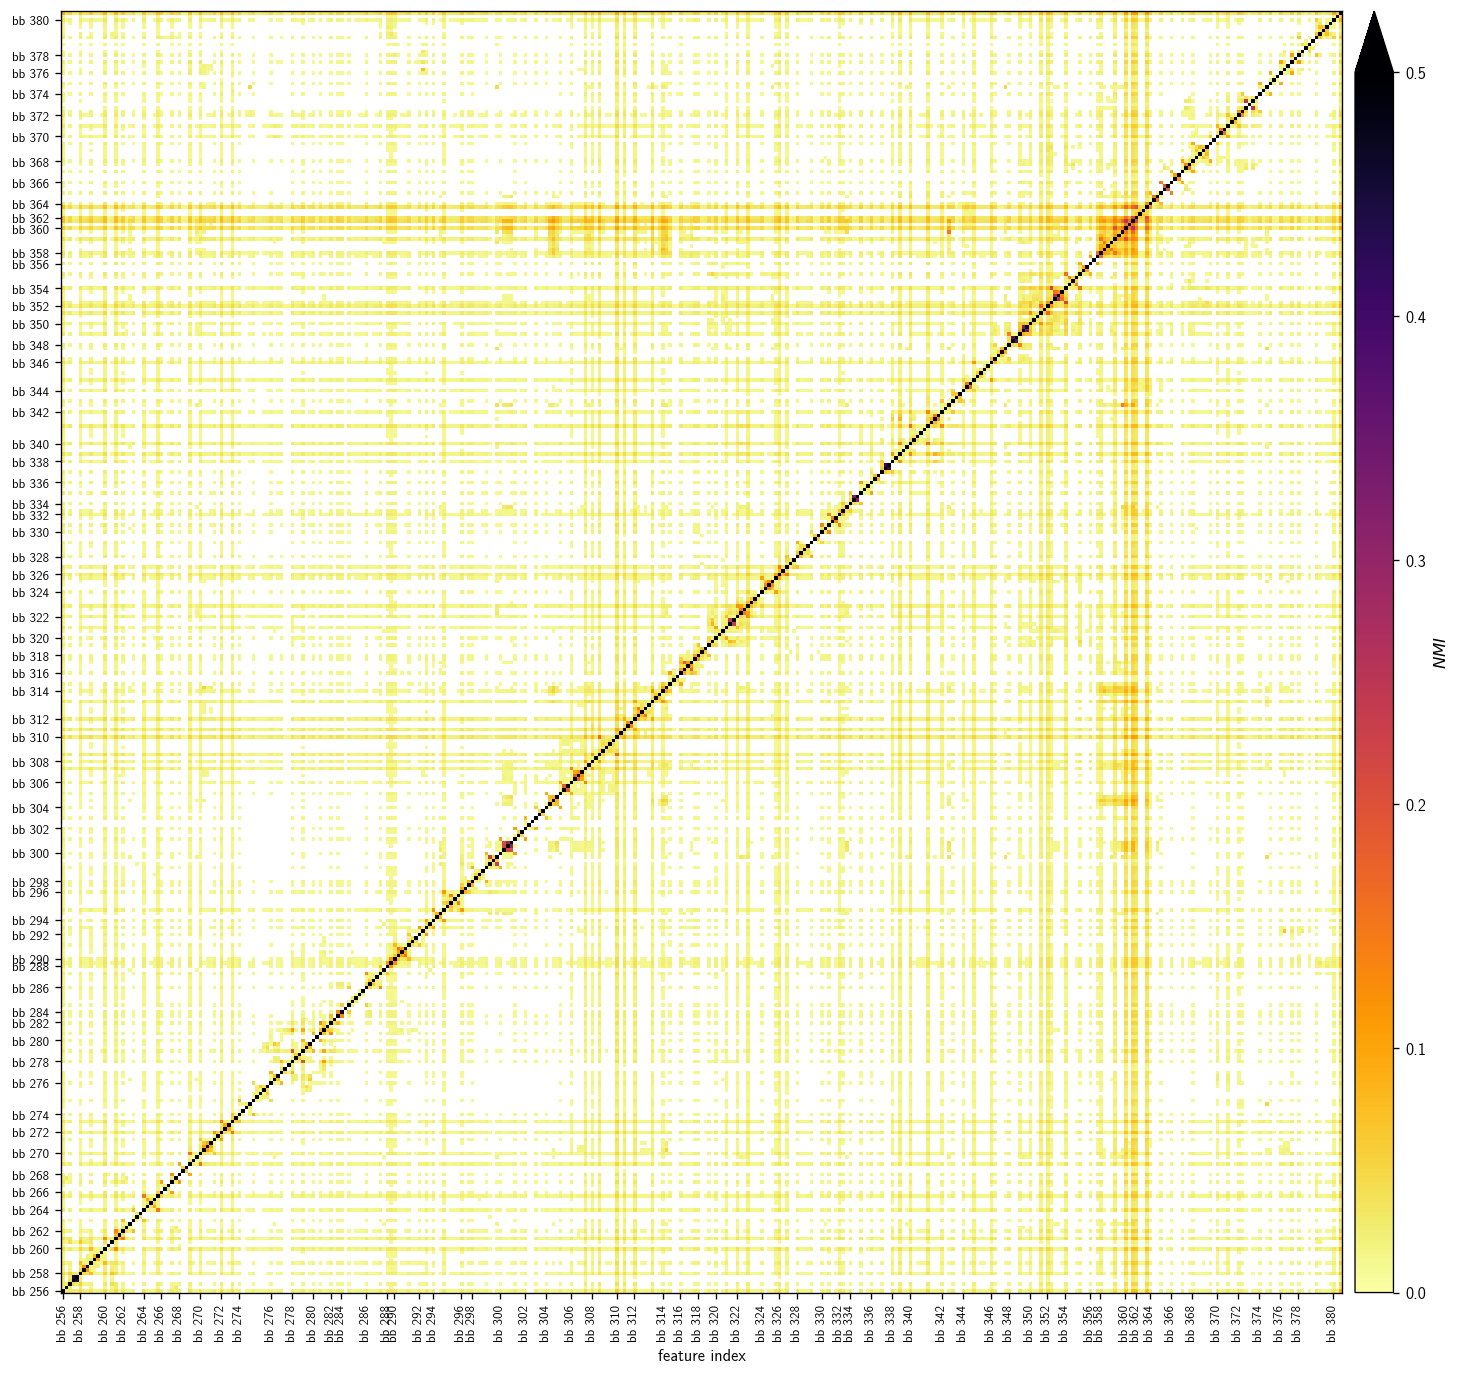

In [581]:
thresholds = (0.01, 1.)
_nmi_matrix = np.copy(nmi_matrix_c)
_nmi_matrix[_nmi_matrix < thresholds[0]] = np.nan
_nmi_matrix[_nmi_matrix > thresholds[1]] = np.nan

fig, ax = plt.subplots(figsize=(12, 12))

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="3%", pad="1%")

matrix_plot = ax.imshow(_nmi_matrix, origin="lower", cmap=mpl.cm.inferno_r, vmin=0, vmax=0.5)
cbar = fig.colorbar(matrix_plot, ax=ax, cax=cax, extend="max", label="$NMI$")
ticks, ticklabels = zip(*[
    (index, format_id(fid))
    for index, fid in enumerate(feature_list_ids_c)
    if fid.startswith("bb")
][::2])
ax.set(**{
    "xticks": ticks,
    "yticks": ticks,
    "xlabel": "feature index",
})
_ = ax.set_xticklabels(ticklabels, rotation=90, fontsize=8)
_ = ax.set_yticklabels(ticklabels, rotation=0, fontsize=8)

fig.tight_layout(pad=0.1)
fig.savefig("bb_chi_matrix.png", facecolor="white", edgecolor='none')

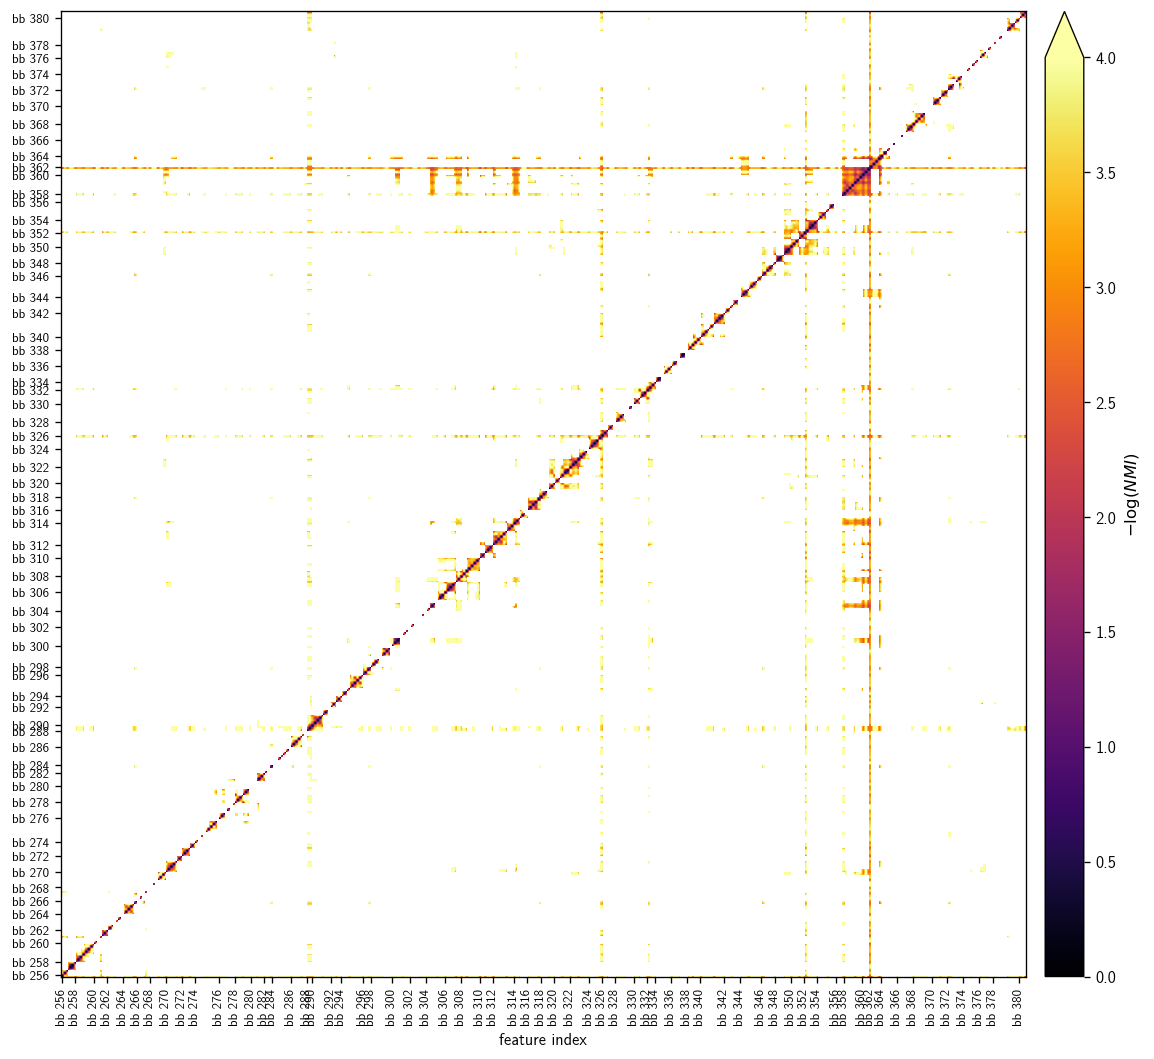

In [580]:
thresholds = (0.01, 1.)
_nmi_matrix = np.copy(nmi_matrix_c)
_nmi_matrix[_nmi_matrix < thresholds[0]] = np.nan
_nmi_matrix[_nmi_matrix > thresholds[1]] = np.nan

_nmi_matrix = -np.log(_nmi_matrix)

fig, ax = plt.subplots(figsize=(11, 11))

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="4%", pad="2%")

matrix_plot = ax.imshow(_nmi_matrix, origin="lower", cmap=mpl.cm.inferno, vmin=0, vmax=4)
cbar = fig.colorbar(matrix_plot, ax=ax, cax=cax, extend="max", label="$-\mathrm{log}(NMI)$")
ticks, ticklabels = zip(*[
    (index, format_id(fid))
    for index, fid in enumerate(feature_list_ids_c)
    if fid.startswith("bb")
][::2])
ax.set(**{
    "xticks": ticks,
    "yticks": ticks,
    "xlabel": "feature index",
})
_ = ax.set_xticklabels(ticklabels, rotation=90, fontsize=8)
_ = ax.set_yticklabels(ticklabels, rotation=0, fontsize=8)

### Projection

Condense matrix to residues-wise values.

In [537]:
feature_list_ids_c

['bb_256',
 'chi1_256',
 'bb_257',
 'chi1_257',
 'chi2_257',
 'bb_258',
 'chi1_258',
 'chi2_258',
 'bb_259',
 'chi1_259',
 'chi2_259',
 'chi3_259',
 'bb_260',
 'chi1_260',
 'chi2_260',
 'bb_261',
 'chi1_261',
 'bb_262',
 'chi1_262',
 'chi2_262',
 'bb_263',
 'chi1_263',
 'chi2_263',
 'bb_264',
 'chi1_264',
 'chi2_264',
 'chi3_264',
 'bb_265',
 'bb_266',
 'chi1_266',
 'chi2_266',
 'bb_267',
 'chi1_267',
 'bb_268',
 'chi1_268',
 'chi2_268',
 'bb_269',
 'chi1_269',
 'chi2_269',
 'bb_270',
 'chi1_270',
 'chi2_270',
 'chi3_270',
 'bb_271',
 'chi1_271',
 'bb_272',
 'chi1_272',
 'chi2_272',
 'bb_273',
 'chi1_273',
 'bb_274',
 'chi1_274',
 'chi2_274',
 'chi3_274',
 'bb_275',
 'chi1_275',
 'chi2_275',
 'chi3_275',
 'chi4_275',
 'bb_276',
 'chi1_276',
 'chi2_276',
 'bb_277',
 'chi1_277',
 'chi2_277',
 'bb_278',
 'chi1_278',
 'chi2_278',
 'bb_279',
 'chi1_279',
 'chi2_279',
 'bb_280',
 'chi1_280',
 'bb_281',
 'chi1_281',
 'chi2_281',
 'bb_282',
 'chi1_282',
 'bb_283',
 'bb_284',
 'chi1_284',
 'bb_

In [551]:
res_range = range(256, 382)

res_array = np.array([
    int(fid.rsplit("_", 1)[-1])
    for fid in feature_list_ids_c
])

tmp_p = []
for res in res_range:
    tmp_p.append(np.where(res_array == res, 1, 0))
    
pl = np.vstack(tmp_p)

In [554]:
projected_nmi_matrix_c = pl @ nmi_matrix_c @ pl.T

In [555]:
projected_nmi_matrix_c.shape

(126, 126)

In [557]:
projected_nmi_matrix_c.max()

6.111011931194026

In [558]:
print(projected_nmi_matrix_c[projected_nmi_matrix_c < 1].max())
print(projected_nmi_matrix_c[projected_nmi_matrix_c > 0].min())

0.7496826221976051
0.011854276827236164


### Plots

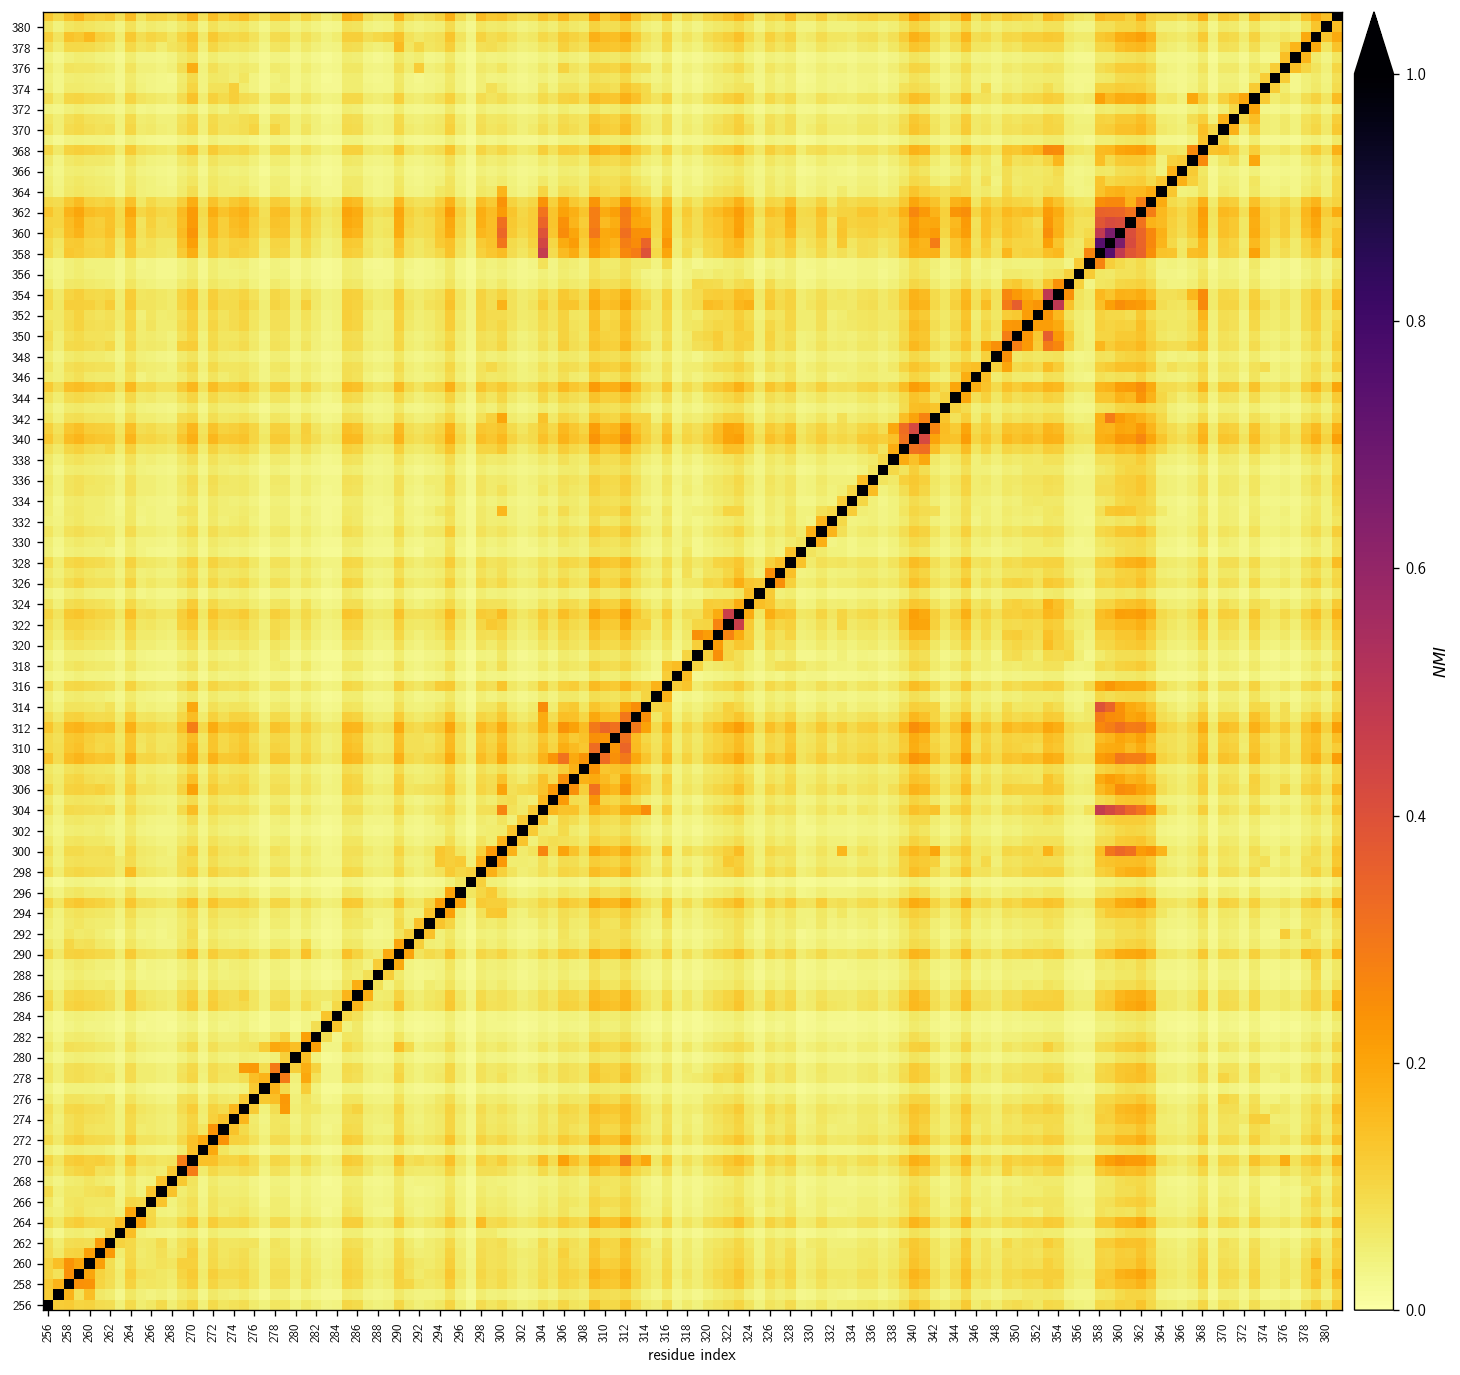

In [579]:
thresholds = (0.01, 8)
_nmi_matrix = np.copy(projected_nmi_matrix_c)
_nmi_matrix[_nmi_matrix < thresholds[0]] = np.nan
_nmi_matrix[_nmi_matrix > thresholds[1]] = np.nan

fig, ax = plt.subplots(figsize=(12, 12))

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="3%", pad="1%")

matrix_plot = ax.imshow(_nmi_matrix, origin="lower", cmap=mpl.cm.inferno_r, vmin=0, vmax=1)
cbar = fig.colorbar(matrix_plot, ax=ax, cax=cax, extend="max", label="$NMI$")
ticks, ticklabels = zip(*[
    (index, res)
    for index, res in enumerate(res_range)
][::2])
ax.set(**{
    "xticks": ticks,
    "yticks": ticks,
    "xlabel": "residue index",
})
_ = ax.set_xticklabels(ticklabels, rotation=90, fontsize=8)
_ = ax.set_yticklabels(ticklabels, rotation=0, fontsize=8)

fig.tight_layout(pad=0.1)
fig.savefig("bb_chi_projected_matrix.png", facecolor="white", edgecolor='none')

In [584]:
projected_nmi_matrix_c

array([[2.04624304, 0.11827571, 0.12282955, ..., 0.11612995, 0.06719644,
        0.12907532],
       [0.11827571, 4.02660254, 0.16887458, ..., 0.07350359, 0.04189872,
        0.09501108],
       [0.12282955, 0.16887458, 3.42626149, ..., 0.13954377, 0.06840545,
        0.13974516],
       ...,
       [0.11612995, 0.07350359, 0.13954377, ..., 5.70967088, 0.13391567,
        0.18922299],
       [0.06719644, 0.04189872, 0.06840545, ..., 0.13391567, 2.03563453,
        0.14540357],
       [0.12907532, 0.09501108, 0.13974516, ..., 0.18922299, 0.14540357,
        1.        ]])

In [103]:
# Get residue node distances from crystal structure

structure_path = pathlib.Path(os.path.expandvars("ref.gro"))
structure = mdtraj.load(str(structure_path))

In [104]:
view = nglview.show_mdtraj(structure)
view.representations = [
    {
        "type": "cartoon",
        "params": {
            "sele": "protein",
            "color": "sstruc"
        }
    },
    {
        "type": "spacefill",
        "params": {
            "sele": "ion"
        }
    },
    {
        "type": "licorice",
        "params": {
            "sele": "358"
        }
    }
]
view

NGLWidget()

In [604]:
calpha_indices = structure.topology.select("protein and (resid 1 to 126) and (name CA)")

In [611]:
print(
    structure.topology.atom(calpha_indices[0]),
    structure.topology.atom(calpha_indices[-1]),
    sep="\n"
)

CYS256-CA
ALA381-CA


In [619]:
calpha_indices[-1]

1971

In [623]:
calpha_positions = structure.xyz[0][calpha_indices]

In [629]:
calpha_positions.shape

(126, 3)

In [628]:
def euclidean_distance(a, b):
    return np.sqrt(np.power(a - b, 2).sum())

In [633]:
type(
    euclidean_distance(
        calpha_positions[0],
        calpha_positions[1]
    )
)

numpy.float32

In [600]:
projected_nmi_matrix_c.shape

(126, 126)

In [636]:
G_cp = networkx.Graph()

for i in range(projected_nmi_matrix_c.shape[0]):
    for j in range(i + 1, projected_nmi_matrix_c.shape[1]):

        nmi = projected_nmi_matrix_c[i, j]

        res_i = i + 256
        res_j = j + 256

        G_cp.add_edge(
            res_i, res_j,
            nmi=nmi,
            distance=float(euclidean_distance(calpha_positions[i], calpha_positions[j]))
        )

In [637]:
networkx.readwrite.gml.write_gml(G_cp, "bb_chi_projected.gml")